In [1]:
# Data Preparation and Exploratory Analysis
import os
import glob

In [2]:
# Define the root directory containing the CSV files
root_directory = '/Users/beckykassaye/Desktop/uni/individ_project/2022-12'

# Define the keywords to keep
keywords_to_keep = ['city-of-london-street.csv', 'metropolitan-street.csv']

# Use glob to find all CSV files in subdirectories
csv_files = glob.glob(os.path.join(root_directory, '**', '*.csv'), recursive=True)

for file_path in csv_files:
    # Extract the filename from the file path
    filename = os.path.basename(file_path)
    
    # Check if the filename contains any of the keywords to keep
    if any(keyword in filename for keyword in keywords_to_keep):
        print(f'Keeping: {file_path}')
    else:
        # Delete the file if it's not in the keywords to keep
        os.remove(file_path)
        print(f'Deleted: {file_path}')

# Remove empty directories
for dirpath, dirnames, filenames in os.walk(root_directory, topdown=False):
    if not dirnames and not filenames:
        os.rmdir(dirpath)
        print(f'Removed empty directory: {dirpath}')

Keeping: /Users/beckykassaye/Desktop/uni/individ_project/2022-12/2021_policedata/2021-09/2021-09-metropolitan-street.csv
Keeping: /Users/beckykassaye/Desktop/uni/individ_project/2022-12/2021_policedata/2021-09/2021-09-city-of-london-street.csv
Keeping: /Users/beckykassaye/Desktop/uni/individ_project/2022-12/2021_policedata/2021-07/2021-07-city-of-london-street.csv
Keeping: /Users/beckykassaye/Desktop/uni/individ_project/2022-12/2021_policedata/2021-07/2021-07-metropolitan-street.csv
Keeping: /Users/beckykassaye/Desktop/uni/individ_project/2022-12/2021_policedata/2021-01/2021-01-metropolitan-street.csv
Keeping: /Users/beckykassaye/Desktop/uni/individ_project/2022-12/2021_policedata/2021-01/2021-01-city-of-london-street.csv
Keeping: /Users/beckykassaye/Desktop/uni/individ_project/2022-12/2021_policedata/2021-06/2021-06-metropolitan-street.csv
Keeping: /Users/beckykassaye/Desktop/uni/individ_project/2022-12/2021_policedata/2021-06/2021-06-city-of-london-street.csv
Keeping: /Users/beckykas

In [3]:
import dask.dataframe as dd
import pandas as pd

# Paths for each year's data
paths = {
    2020: '/Users/beckykassaye/Desktop/uni/individ_project/2022-12/2020_policedata/**/*.csv',
    2021: '/Users/beckykassaye/Desktop/uni/individ_project/2022-12/2021_policedata/**/*.csv',
    2022: '/Users/beckykassaye/Desktop/uni/individ_project/2022-12/2022_policedata/**/*.csv'
}

In [4]:
# Create a list to hold the df for each year
dfs = []

# Process each year's crime data
for year, path in paths.items():
    # Find all CSV files in directory
    police_data_files = glob.glob(path, recursive=True)

    # Use Dask to read all CSV files and concatenate them
    try:
        # Read CSV files selecting only the specified columns
        crime_df = dd.read_csv(police_data_files, usecols=['LSOA code', 'LSOA name', 'Crime type'])

        # Drop rows with missing or blank 'LSOA code' or 'LSOA name'
        crime_df = crime_df.dropna(subset=['LSOA code', 'LSOA name'])
        crime_df = crime_df[crime_df['LSOA code'].str.strip() != '']
        crime_df = crime_df[crime_df['LSOA name'].str.strip() != '']

        # Add a column for the year
        crime_df['year'] = year

        # Compute the final df
        crime_df = crime_df.compute()

        # Append the df to the list
        dfs.append(crime_df)
    except Exception as e:
        print(f"Error reading CSV files with Dask for {year}: {e}")

# Concatenate all dfs into one df
combined_crimedf = pd.concat(dfs, ignore_index=True)

# Printing the first few rows of the combined df to verify
print(combined_crimedf.head())

   LSOA code                  LSOA name             Crime type  year
0  E01031469                  Arun 009F            Other theft  2020
1  E01000027  Barking and Dagenham 001A  Anti-social behaviour  2020
2  E01000027  Barking and Dagenham 001A  Anti-social behaviour  2020
3  E01000027  Barking and Dagenham 001A  Anti-social behaviour  2020
4  E01000027  Barking and Dagenham 001A  Anti-social behaviour  2020


In [5]:
# Find the locations code CSV file in the specified directory
loc_code_df = pd.read_csv('/Users/beckykassaye/Desktop/uni/Individual_Group_Project/location_codes.csv')

# Printing the first couple rows of csv file to verify
print(loc_code_df.head())

# Identifying the data types in the csv file
print(loc_code_df.info())

/var/folders/qy/0_d5tnf902v8gq6h02wv_gfc0000gn/T/ipykernel_21866/1661888959.py:2: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  loc_code_df = pd.read_csv('/Users/beckykassaye/Desktop/uni/Individual_Group_Project/location_codes.csv')


      OA21CD   LSOA21CD             LSOA21NM   MSOA21CD            MSOA21NM  \
0  E00000001  E01000001  City of London 001A  E02000001  City of London 001   
1  E00000003  E01000001  City of London 001A  E02000001  City of London 001   
2  E00000005  E01000001  City of London 001A  E02000001  City of London 001   
3  E00000007  E01000001  City of London 001A  E02000001  City of London 001   
4  E00000010  E01000003  City of London 001C  E02000001  City of London 001   

    LEP22CD1                                LEP22NM1 LEP22CD2 LEP22NM2  \
0  E37000051  The London Economic Action Partnership      NaN      NaN   
1  E37000051  The London Economic Action Partnership      NaN      NaN   
2  E37000051  The London Economic Action Partnership      NaN      NaN   
3  E37000051  The London Economic Action Partnership      NaN      NaN   
4  E37000051  The London Economic Action Partnership      NaN      NaN   

     LAD22CD         LAD22NM  ObjectId  
0  E09000001  City of London         1 

In [6]:
# Filter rows where 'LEP22CD1' is 'E37000051' - This ensures only rows from London are picked
filtered_loc_code_df = loc_code_df[loc_code_df['LEP22CD1'] == 'E37000051']

# Create a new df with only the specified columns
loc_code_df1 = filtered_loc_code_df[['LSOA21CD', 'LAD22CD', 'LAD22NM']]

# Remove duplicates in 'LSOA21CD' column
loc_code_df1 = loc_code_df1.drop_duplicates(subset=['LSOA21CD'])

# Renaming column 'LSOA21CD' to 'LSOA code'
loc_code_df1 = loc_code_df1.rename(columns={'LSOA21CD': 'LSOA code'})

# Printing the first few rows of the new df
print(loc_code_df1.head())

    LSOA code    LAD22CD         LAD22NM
0   E01000001  E09000001  City of London
4   E01000003  E09000001  City of London
6   E01000002  E09000001  City of London
12  E01032739  E09000001  City of London
13  E01032740  E09000001  City of London


In [7]:
# Merge the two dfs on 'LSOA code'
merged_df = pd.merge(combined_crimedf, loc_code_df1, on='LSOA code', how='inner')

# Drop rows where 'LAD22CD' or 'LAD22NM' are NaN
merged_df = merged_df.dropna(subset=['LAD22CD', 'LAD22NM'])

# Printing the first couple rows of the merged df
print(merged_df.head())

   LSOA code                  LSOA name             Crime type  year  \
0  E01000027  Barking and Dagenham 001A  Anti-social behaviour  2020   
1  E01000027  Barking and Dagenham 001A  Anti-social behaviour  2020   
2  E01000027  Barking and Dagenham 001A  Anti-social behaviour  2020   
3  E01000027  Barking and Dagenham 001A  Anti-social behaviour  2020   
4  E01000027  Barking and Dagenham 001A  Anti-social behaviour  2020   

     LAD22CD               LAD22NM  
0  E09000002  Barking and Dagenham  
1  E09000002  Barking and Dagenham  
2  E09000002  Barking and Dagenham  
3  E09000002  Barking and Dagenham  
4  E09000002  Barking and Dagenham  


In [8]:
# Aggregating by local authority
aggregated_merged_df = merged_df.groupby(['LAD22CD', 'LAD22NM', 'Crime type', 'year']).size().reset_index(name='counts')

# Printing the first few rows of the aggregated merged df
print(aggregated_merged_df.head())

     LAD22CD         LAD22NM             Crime type  year  counts
0  E09000001  City of London  Anti-social behaviour  2020     728
1  E09000001  City of London  Anti-social behaviour  2021     972
2  E09000001  City of London  Anti-social behaviour  2022     855
3  E09000001  City of London          Bicycle theft  2020     456
4  E09000001  City of London          Bicycle theft  2021     283


In [9]:
# Filtering the crime types 'anti-social behaviour', 'violence' and 'burglary' from the merged df
crime_types = ['Anti-social behaviour', 'Violence and sexual offences', 'Burglary']
specified_crime_df = aggregated_merged_df[aggregated_merged_df['Crime type'].isin(crime_types)]

# Printing the first first rows 
specified_crime_df.head(20)

,LAD22CD,LAD22NM,Crime type,year,counts
0,E09000001,City of London,Anti-social behaviour,2020,728
1,E09000001,City of London,Anti-social behaviour,2021,972
2,E09000001,City of London,Anti-social behaviour,2022,855
6,E09000001,City of London,Burglary,2020,203
7,E09000001,City of London,Burglary,2021,198
8,E09000001,City of London,Burglary,2022,304
39,E09000001,City of London,Violence and sexual offences,2020,673
40,E09000001,City of London,Violence and sexual offences,2021,1043
41,E09000001,City of London,Violence and sexual offences,2022,1303
42,E09000002,Barking and Dagenham,Anti-social behaviour,2020,7458


In [10]:
import pandas as pd

# Paths for each year's employment data
employment_paths = {
    2020: '/Users/beckykassaye/Desktop/uni/individ_project/2020-employment-rate-gender-age-disability.csv',
    2021: '/Users/beckykassaye/Desktop/uni/individ_project/2021-employment-rate-gender-age-disability.csv',
    2022: '/Users/beckykassaye/Desktop/uni/individ_project/2022-employment-rate-gender-age-disability.csv'
}


In [11]:
employment_dfs = []

# Process each year's employment data
for year, path in employment_paths.items():
    try:
        # Read the employment csv file
        employment_df = pd.read_csv(path)

        # Add a column for the year
        employment_df['year'] = year

        # Replace symbols with NaN
        employment_df.replace({'!': pd.NA, '*': pd.NA, '-': pd.NA}, inplace=True)

        # Renaming the columns
        employment_df = employment_df.rename(columns={
            'Code': 'LAD22CD',
            'Area': 'LAD22NM',
            'numerator': 'Employed Individuals',
            'denominator': 'Total Population',
            'percent': 'Employment Rate (%)',
            'conf': 'Confidence Interval',
            'Males numerator': 'Employed Male Individuals',
            'Males denominator': 'Total Male Population',
            'Males percent': 'Male Employment Rate (%)',
            'Males conf': 'Male Confidence Interval',
            'Females numerator': 'Employed Female Individuals',
            'Females denominator': 'Total Female Population',
            'Females percent': 'Female Employment Rate (%)',
            'Females conf': 'Female Confidence Interval',
            'Disabled numerator': 'Employed Disabled Individuals',
            'Disabled denominator': 'Total Disabled Population',
            'Disabled percent': 'Disabled Employment Rate (%)',
            'Disabled conf': 'Disabled Confidence Interval'
        })

        # Append the df to the list
        employment_dfs.append(employment_df)

        # Print the first few rows to verify
        print(f"Employment data for {year}:")
        print(employment_df.head())

    except FileNotFoundError:
        print(f"No employment file found for {year} at {path}")

# Concatenate all employment dfs into one
combined_employment_df = pd.concat(employment_dfs, ignore_index=True)

# Print few rows of combined df to verify
print("Combined employment data:")
print(combined_employment_df.head())

Employment data for 2020:
     LAD22CD               LAD22NM  Employed Individuals  Total Population  \
0  E09000001        City of London                9100.0            9100.0   
1  E09000002  Barking and Dagenham               93700.0          139500.0   
2  E09000003                Barnet              192000.0          257500.0   
3  E09000004                Bexley              123500.0          159300.0   
4  E09000005                 Brent              157300.0          221100.0   

   Employment Rate (%) Confidence Interval Employed Male Individuals  \
0                100.0                <NA>                         #   
1                 67.2                 6.2                   49000.0   
2                 74.6                 4.7                  109700.0   
3                 77.5                 4.3                   59500.0   
4                 71.2                 6.0                   81600.0   

  Total Male Population  Male Employment Rate (%) Male Confidence Interv

In [12]:
# Merge the crime data with the employment data based on 'LAD22CD', 'LAD22NM', and 'year'
merged_df0 = pd.merge(specified_crime_df, combined_employment_df, on=['LAD22CD', 'LAD22NM', 'year'], how='inner')

# Print the first few rows of the merged dataframe
print("Merged crime and employment data:")
print(merged_df0.head())

# Load population data
population_df = pd.read_csv('/Users/beckykassaye/Desktop/uni/Individual_Group_Project/population_data.csv')

# Drop columns 'Name' and 'Geography'
population_df = population_df.drop(columns=['Name', 'Geography'])

# Rename columns 'Code' into 'LAD22CD' and 'All ages' into 'Total borough population'
population_df = population_df.rename(columns={'Code': 'LAD22CD', 'All ages': 'Total borough population'})

# Print the first few rows to verify the changes
print("Population data:")
print(population_df.head())

Merged crime and employment data:
     LAD22CD         LAD22NM                    Crime type  year  counts  \
0  E09000001  City of London         Anti-social behaviour  2020     728   
1  E09000001  City of London                      Burglary  2020     203   
2  E09000001  City of London  Violence and sexual offences  2020     673   
3  E09000001  City of London         Anti-social behaviour  2021     972   
4  E09000001  City of London                      Burglary  2021     198   

  Employed Individuals Total Population  Employment Rate (%)  \
0               9100.0           9100.0                100.0   
1               9100.0           9100.0                100.0   
2               9100.0           9100.0                100.0   
3              25800.0          25800.0                100.0   
4              25800.0          25800.0                100.0   

  Confidence Interval Employed Male Individuals  ... Male Employment Rate (%)  \
0                <NA>                      

In [13]:
# Merge the population data with the previously merged dataframe on 'LAD22CD'
merged_df1 = pd.merge(merged_df0, population_df, on='LAD22CD', how='inner')

# Calculate the crime rate per 1,000 people
merged_df1['Crime Rate per 1k population'] = (merged_df1['counts'] / merged_df1['Total borough population']) * 1000

# Print the first few rows of the final merged dataframe
print("Final merged dataframe with crime rate:")
print(merged_df1.head())

# Save the final merged dataframe to a CSV file
output_path = '/Users/beckykassaye/Desktop/uni/individ_project/final_merged_data_with_crime_rate.csv'
merged_df1.to_csv(output_path, index=False)

Final merged dataframe with crime rate:
     LAD22CD         LAD22NM                    Crime type  year  counts  \
0  E09000001  City of London         Anti-social behaviour  2020     728   
1  E09000001  City of London                      Burglary  2020     203   
2  E09000001  City of London  Violence and sexual offences  2020     673   
3  E09000001  City of London         Anti-social behaviour  2021     972   
4  E09000001  City of London                      Burglary  2021     198   

  Employed Individuals Total Population  Employment Rate (%)  \
0               9100.0           9100.0                100.0   
1               9100.0           9100.0                100.0   
2               9100.0           9100.0                100.0   
3              25800.0          25800.0                100.0   
4              25800.0          25800.0                100.0   

  Confidence Interval Employed Male Individuals  ...  \
0                <NA>                         #  ...   
1     

In [14]:
# Filter the merged_df1 for the crime type 'Anti-social behaviour'
antisocial_behaviour_df = merged_df1[merged_df1['Crime type'] == 'Anti-social behaviour']

# Select only the required columns: "LAD22CD", "LAD22NM", "Crime type", "year", 
# "Employment Rate (%)", and "Anti-social behaviour Crime Rate per 1k population"
antisocial_behaviour_df = antisocial_behaviour_df[['LAD22CD', 'LAD22NM', 'Crime type', 'year', 'Employment Rate (%)', 'Crime Rate per 1k population']]

# Renaming 'Crime Rate per 1k population' to 'Anti-social behaviour Crime Rate per 1k population'
antisocial_behaviour_df = antisocial_behaviour_df.rename(columns={'Crime Rate per 1k population': 'Anti-social behaviour Crime Rate per 1k population'})

# Display the first few rows to verify
print(antisocial_behaviour_df)
antisocial_behaviour_df.to_csv('antisocial_behaviour_df.csv', index=False)

       LAD22CD               LAD22NM             Crime type  year  \
0    E09000001        City of London  Anti-social behaviour  2020   
3    E09000001        City of London  Anti-social behaviour  2021   
6    E09000001        City of London  Anti-social behaviour  2022   
9    E09000002  Barking and Dagenham  Anti-social behaviour  2020   
12   E09000002  Barking and Dagenham  Anti-social behaviour  2021   
..         ...                   ...                    ...   ...   
282  E09000032            Wandsworth  Anti-social behaviour  2021   
285  E09000032            Wandsworth  Anti-social behaviour  2022   
288  E09000033           Westminster  Anti-social behaviour  2020   
291  E09000033           Westminster  Anti-social behaviour  2021   
294  E09000033           Westminster  Anti-social behaviour  2022   

     Employment Rate (%)  Anti-social behaviour Crime Rate per 1k population  
0                  100.0                                          67.115331   
3            

In [15]:
# Example for 'Violence and sexual offences'
violence_sexual_offences_df = merged_df1[merged_df1['Crime type'] == 'Violence and sexual offences']
violence_sexual_offences_df = violence_sexual_offences_df[['LAD22CD', 'LAD22NM', 'Crime type', 'year', 'Employment Rate (%)', 'Crime Rate per 1k population']]
violence_sexual_offences_df = violence_sexual_offences_df.rename(columns={'Crime Rate per 1k population': 'Violence and sexual offences Crime Rate per 1k population'})
print(violence_sexual_offences_df.head())
violence_sexual_offences_df.to_csv('violence_sexual_offences_df.csv', index=False)

# Example for 'Burglary'
burglary_df = merged_df1[merged_df1['Crime type'] == 'Burglary']
burglary_df = burglary_df[['LAD22CD', 'LAD22NM', 'Crime type', 'year', 'Employment Rate (%)', 'Crime Rate per 1k population']]
burglary_df = burglary_df.rename(columns={'Crime Rate per 1k population': 'Burglary Crime Rate per 1k population'})
print(burglary_df.head())
burglary_df.to_csv('burglary_df.csv', index=False)


      LAD22CD               LAD22NM                    Crime type  year  \
2   E09000001        City of London  Violence and sexual offences  2020   
5   E09000001        City of London  Violence and sexual offences  2021   
8   E09000001        City of London  Violence and sexual offences  2022   
11  E09000002  Barking and Dagenham  Violence and sexual offences  2020   
14  E09000002  Barking and Dagenham  Violence and sexual offences  2021   

    Employment Rate (%)  \
2                 100.0   
5                 100.0   
8                 100.0   
11                 67.2   
14                 65.6   

    Violence and sexual offences Crime Rate per 1k population  
2                                           62.044805          
5                                           96.155619          
8                                          120.125380          
11                                          25.987309          
14                                          26.973708          
  


Correlation between Employment Rate and Anti-social behaviour Crime Rate per 1k population by year:
year
2020   -0.055365
2021    0.387368
2022    0.204045
dtype: float64


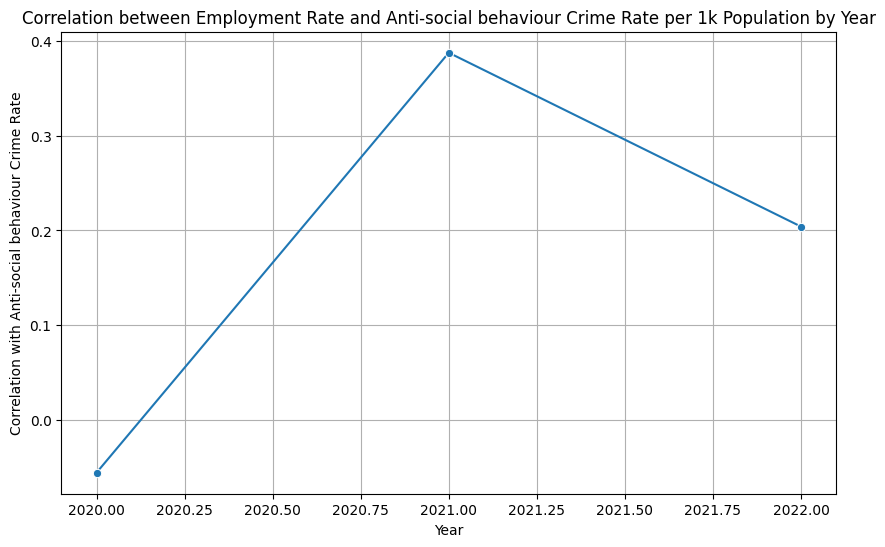

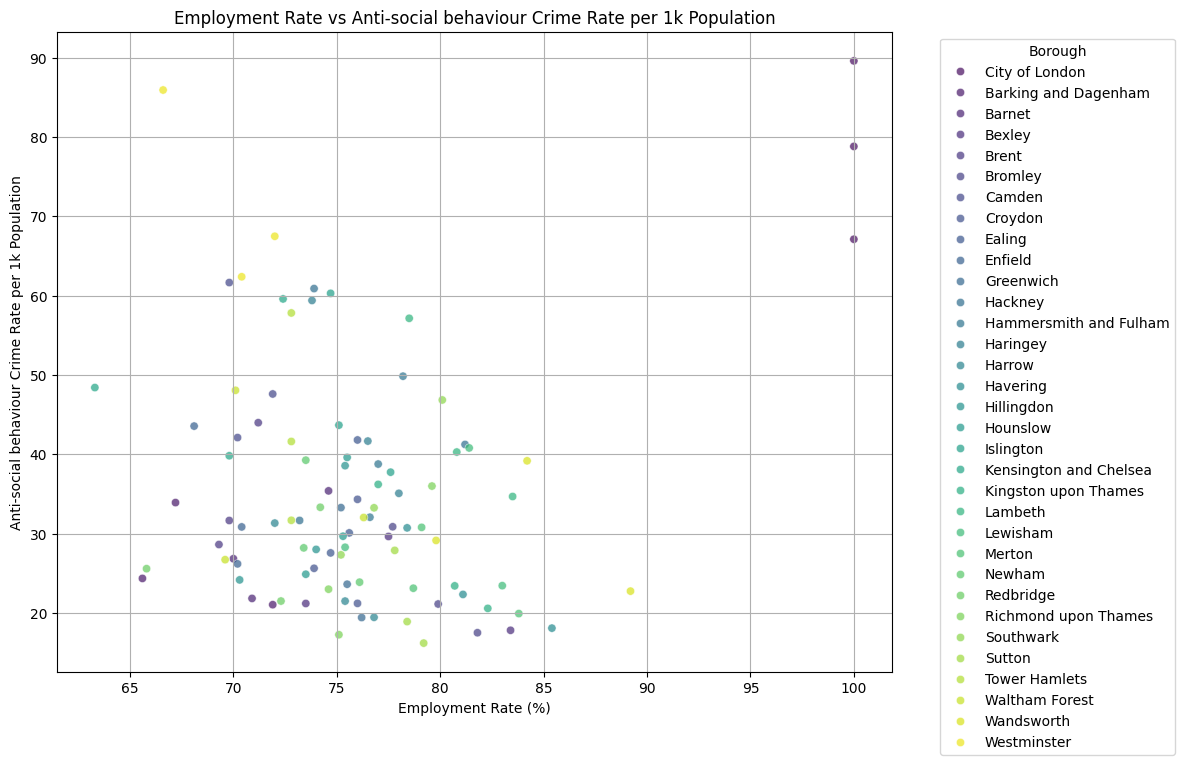

/var/folders/qy/0_d5tnf902v8gq6h02wv_gfc0000gn/T/ipykernel_21866/49060619.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


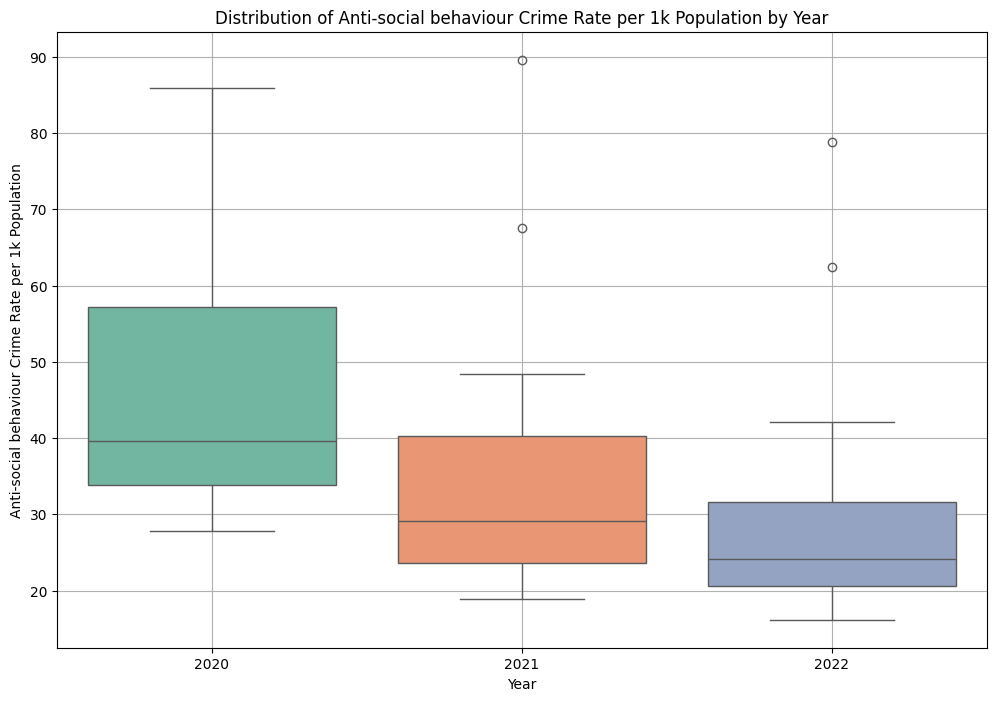


Correlation between Employment Rate and Violence and sexual offences Crime Rate per 1k population by year:
year
2020    0.463282
2021    0.598032
2022    0.497826
dtype: float64


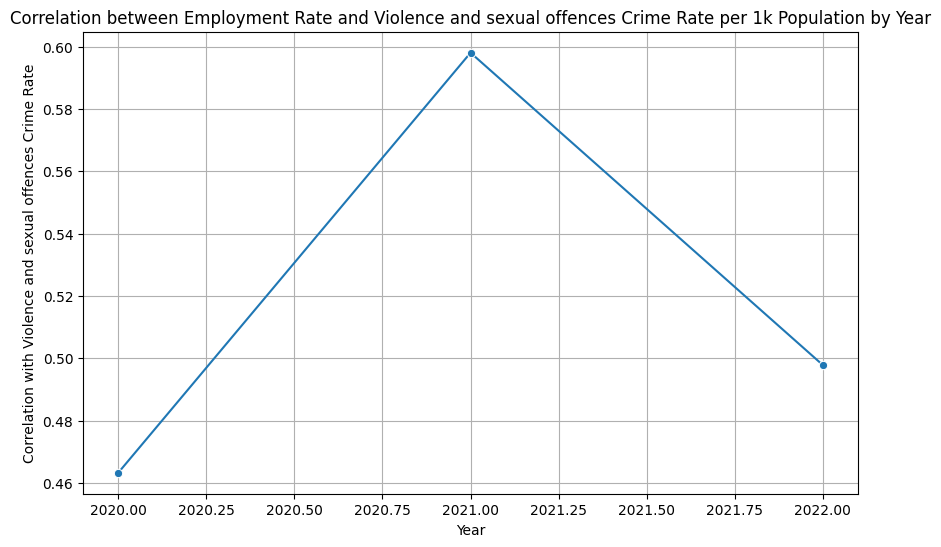

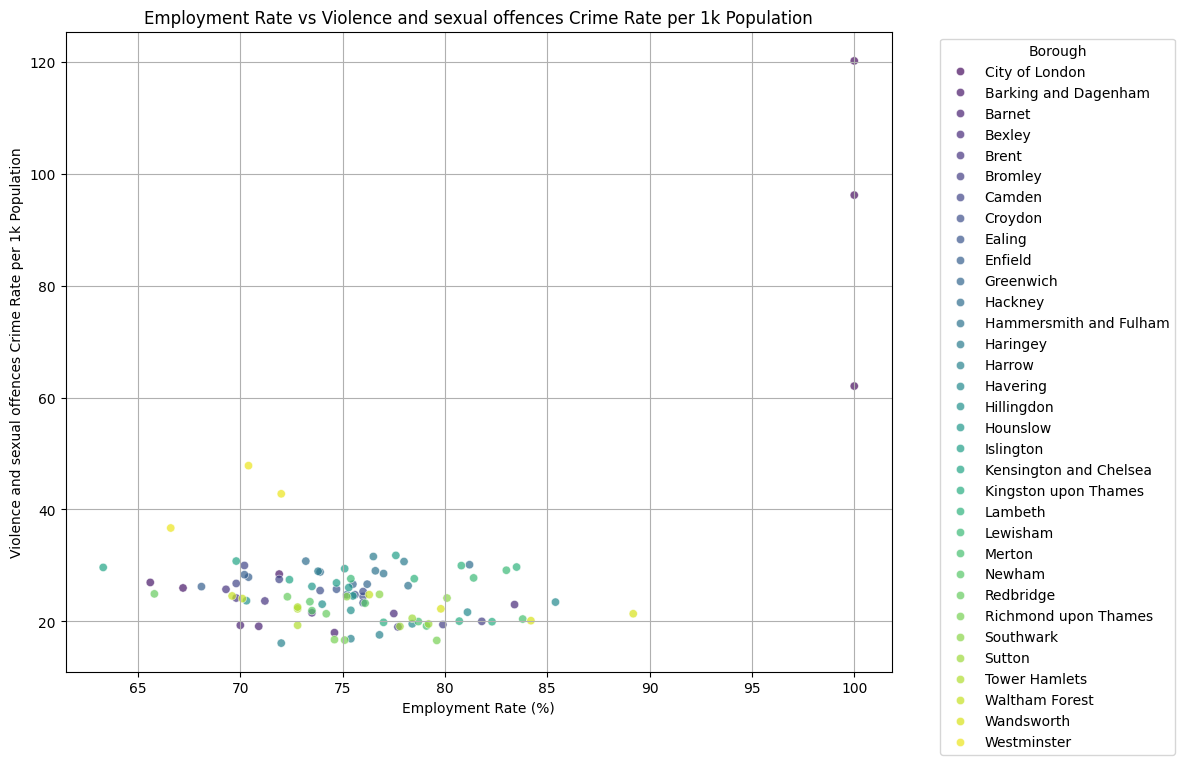

/var/folders/qy/0_d5tnf902v8gq6h02wv_gfc0000gn/T/ipykernel_21866/49060619.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


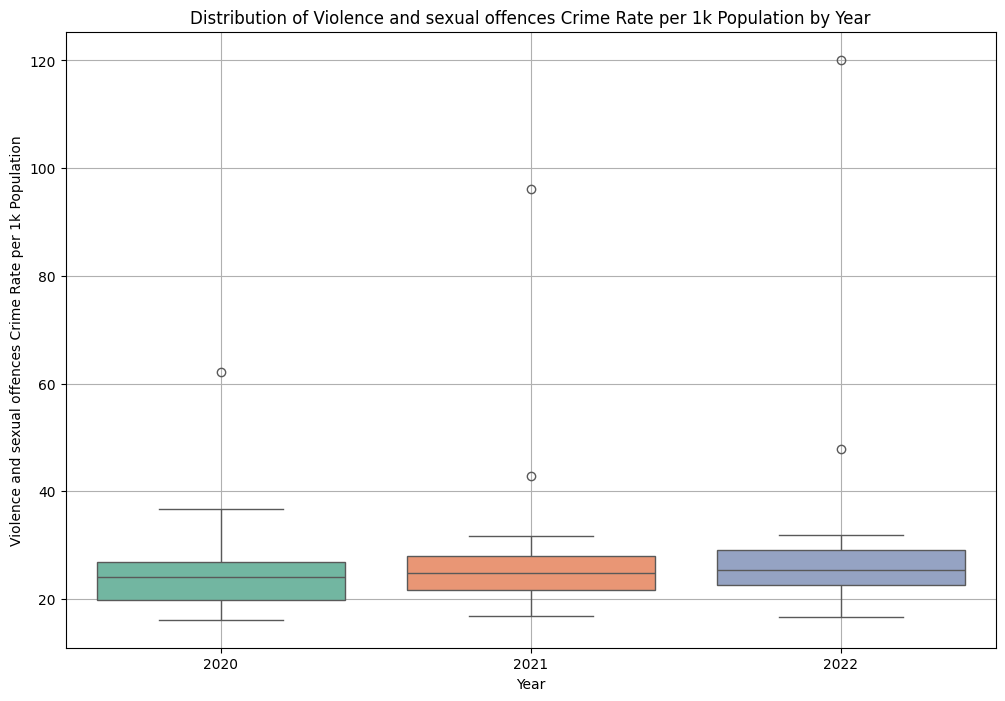


Correlation between Employment Rate and Burglary Crime Rate per 1k population by year:
year
2020    0.391634
2021    0.499218
2022    0.446367
dtype: float64


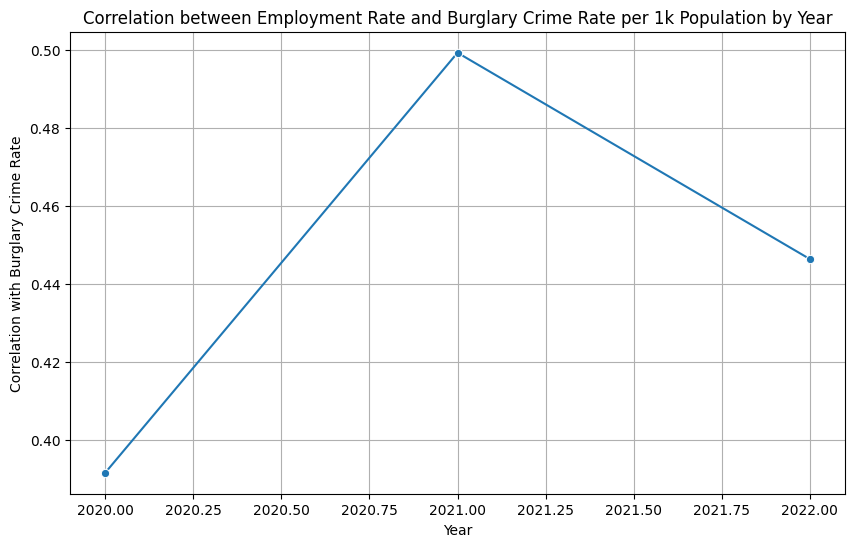

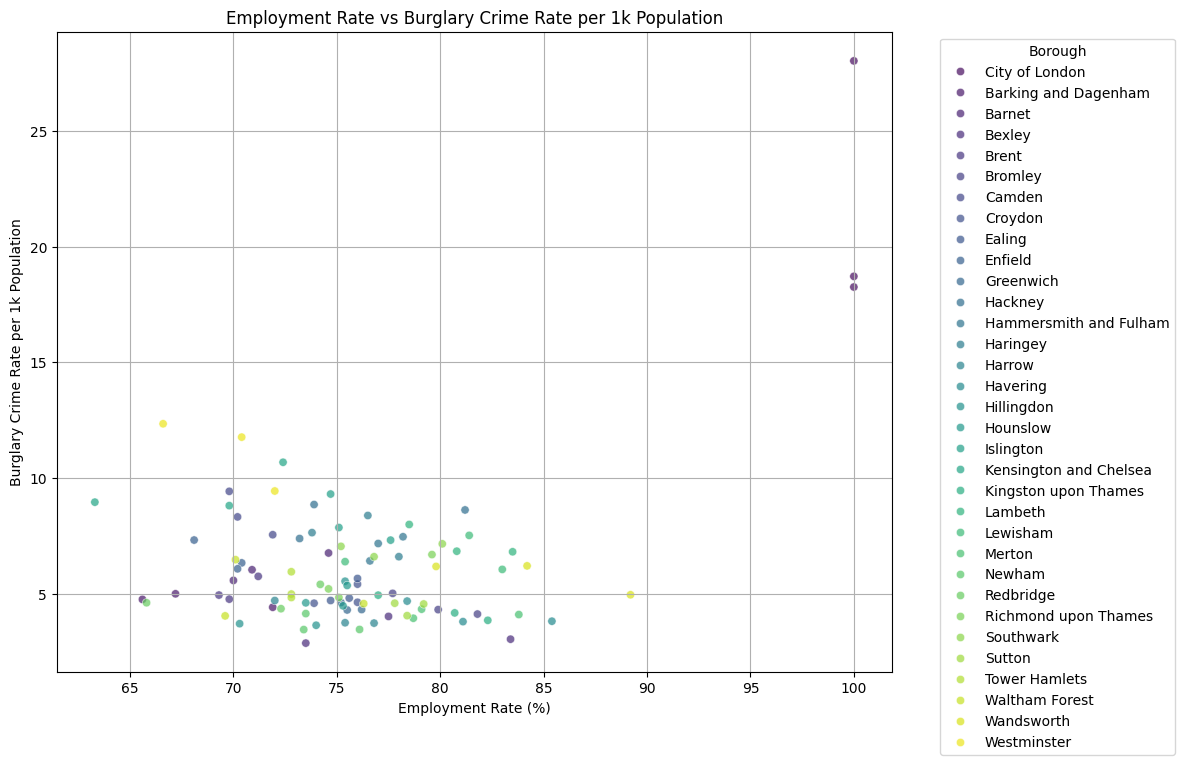

/var/folders/qy/0_d5tnf902v8gq6h02wv_gfc0000gn/T/ipykernel_21866/49060619.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


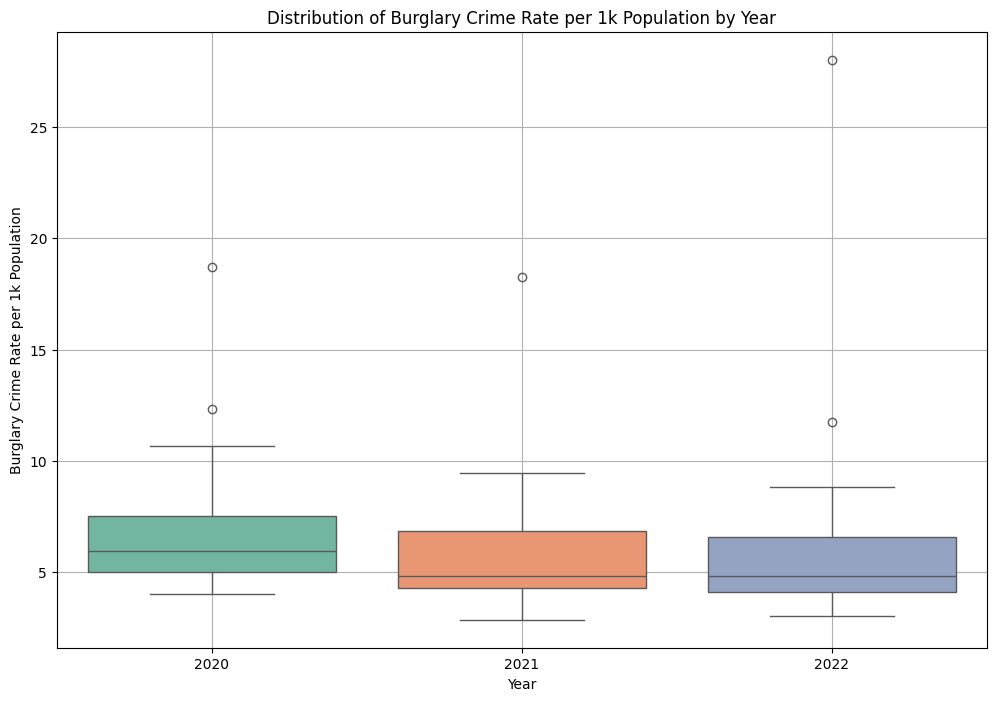

In [16]:
# CORRELATION ANALYSIS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to perform correlation analysis and visualization for a given dataframe by year
def correlation_analysis_by_year(crime_df, crime_type):
    # Ensure columns are numeric
    crime_df['Employment Rate (%)'] = pd.to_numeric(crime_df['Employment Rate (%)'], errors='coerce')
    crime_df[f'{crime_type} Crime Rate per 1k population'] = pd.to_numeric(crime_df[f'{crime_type} Crime Rate per 1k population'], errors='coerce')

    # Group by year and calculate correlation for each year
    correlation_by_year = crime_df.groupby('year').apply(
        lambda df: df[['Employment Rate (%)', f'{crime_type} Crime Rate per 1k population']].corr().iloc[0, 1]
    )

    print(f"\nCorrelation between Employment Rate and {crime_type} Crime Rate per 1k population by year:")
    print(correlation_by_year)

    # Visualize the correlation over years
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=correlation_by_year.index, y=correlation_by_year.values, marker='o')
    plt.title(f'Correlation between Employment Rate and {crime_type} Crime Rate per 1k Population by Year')
    plt.xlabel('Year')
    plt.ylabel(f'Correlation with {crime_type} Crime Rate')
    plt.grid(True)
    plt.show()
    
    # Scatter Plot: Employment Rate vs Crime Rate per 1k population
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(
        data=crime_df,
        x='Employment Rate (%)',
        y=f'{crime_type} Crime Rate per 1k population',
        hue='LAD22NM',  # Borough names for hue
        palette='viridis',
        legend='full',
        alpha=0.7
    )
    plt.title(f'Employment Rate vs {crime_type} Crime Rate per 1k Population')
    plt.xlabel('Employment Rate (%)')
    plt.ylabel(f'{crime_type} Crime Rate per 1k Population')
    plt.legend(title='Borough', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Box Plot: Crime Rate per 1k population by Year
    plt.figure(figsize=(12, 8))
    sns.boxplot(
        data=crime_df,
        x='year',
        y=f'{crime_type} Crime Rate per 1k population',
        palette='Set2'
    )
    plt.title(f'Distribution of {crime_type} Crime Rate per 1k Population by Year')
    plt.xlabel('Year')
    plt.ylabel(f'{crime_type} Crime Rate per 1k Population')
    plt.grid(True)
    plt.show()

# Perform correlation analysis for each crime type by year
correlation_analysis_by_year(antisocial_behaviour_df, 'Anti-social behaviour')
correlation_analysis_by_year(violence_sexual_offences_df, 'Violence and sexual offences')
correlation_analysis_by_year(burglary_df, 'Burglary')


/var/folders/qy/0_d5tnf902v8gq6h02wv_gfc0000gn/T/ipykernel_21866/494227149.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_df['Employment Rate (%)'] = pd.to_numeric(crime_df['Employment Rate (%)'], errors='coerce')
/var/folders/qy/0_d5tnf902v8gq6h02wv_gfc0000gn/T/ipykernel_21866/494227149.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_df[f'{crime_type} Crime Rate per 1k population'] = pd.to_numeric(crime_df[f'{crime_type} Crime Rate per 1k population'], errors='coerce')



Correlation between Employment Rate and Anti-social behaviour Crime Rate per 1k population by year:
year
2020   -0.268838
2021   -0.171585
2022   -0.361738
dtype: float64


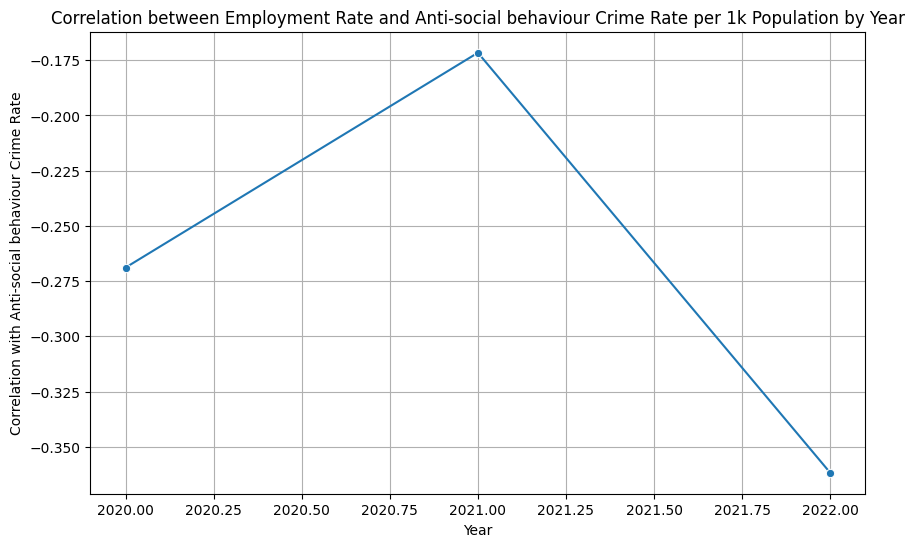

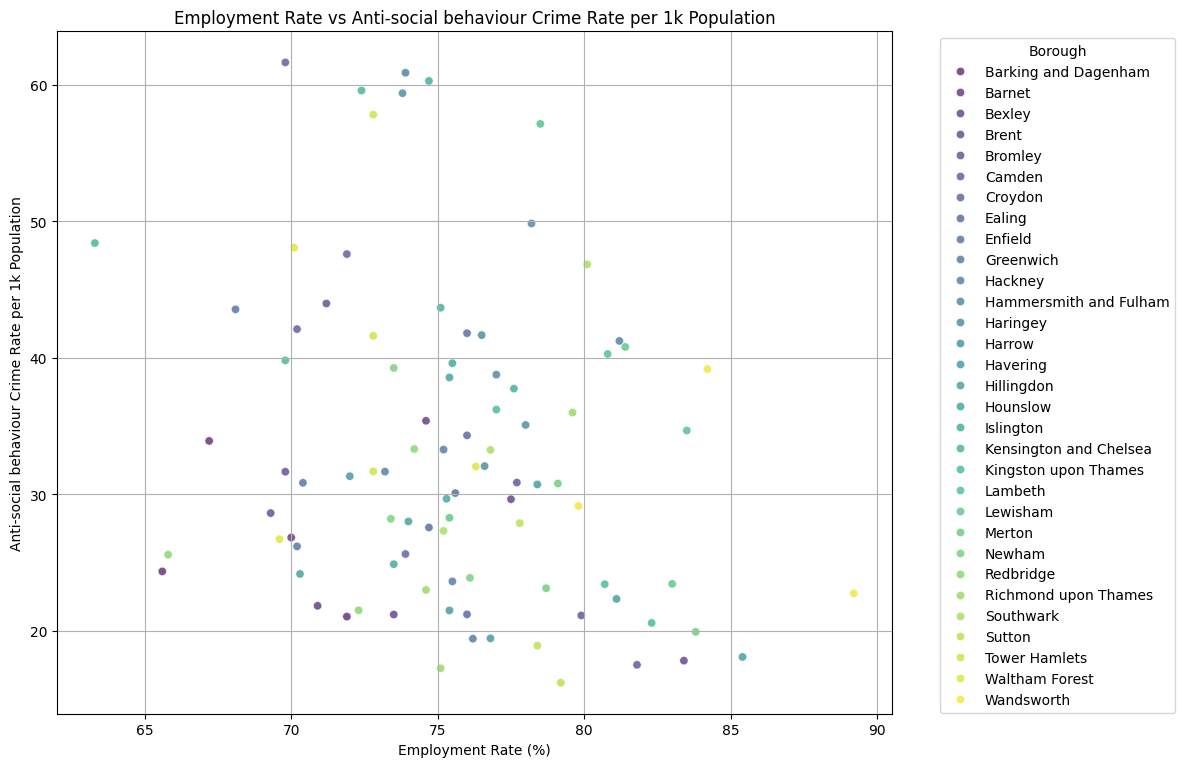

/var/folders/qy/0_d5tnf902v8gq6h02wv_gfc0000gn/T/ipykernel_21866/494227149.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


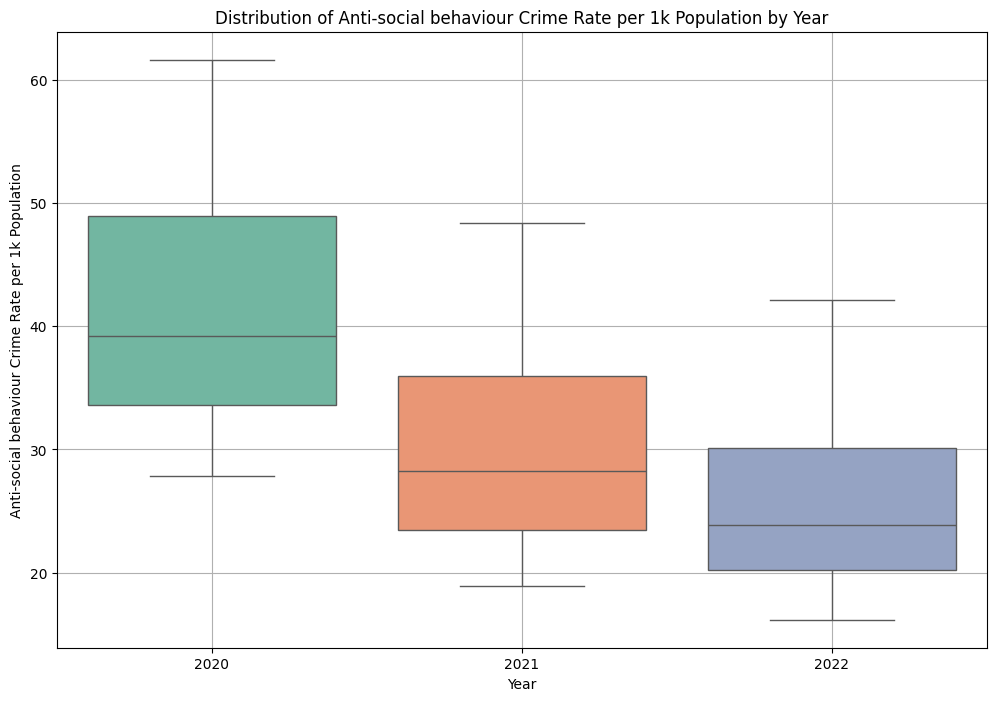

/var/folders/qy/0_d5tnf902v8gq6h02wv_gfc0000gn/T/ipykernel_21866/494227149.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_df['Employment Rate (%)'] = pd.to_numeric(crime_df['Employment Rate (%)'], errors='coerce')
/var/folders/qy/0_d5tnf902v8gq6h02wv_gfc0000gn/T/ipykernel_21866/494227149.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_df[f'{crime_type} Crime Rate per 1k population'] = pd.to_numeric(crime_df[f'{crime_type} Crime Rate per 1k population'], errors='coerce')



Correlation between Employment Rate and Violence and sexual offences Crime Rate per 1k population by year:
year
2020   -0.267911
2021   -0.167850
2022   -0.248901
dtype: float64


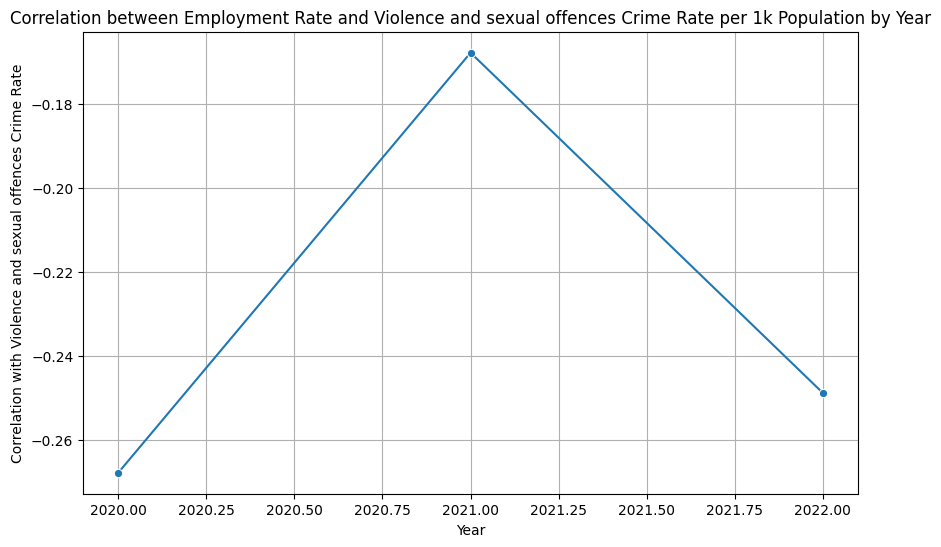

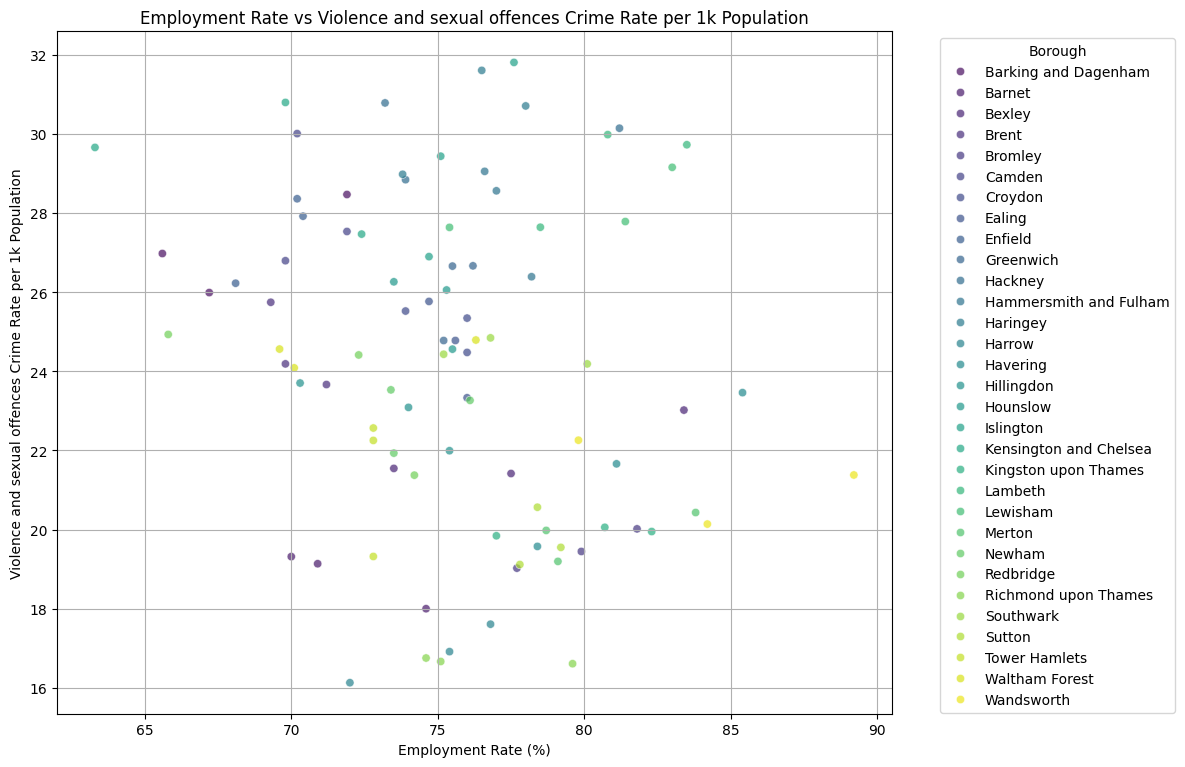

/var/folders/qy/0_d5tnf902v8gq6h02wv_gfc0000gn/T/ipykernel_21866/494227149.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


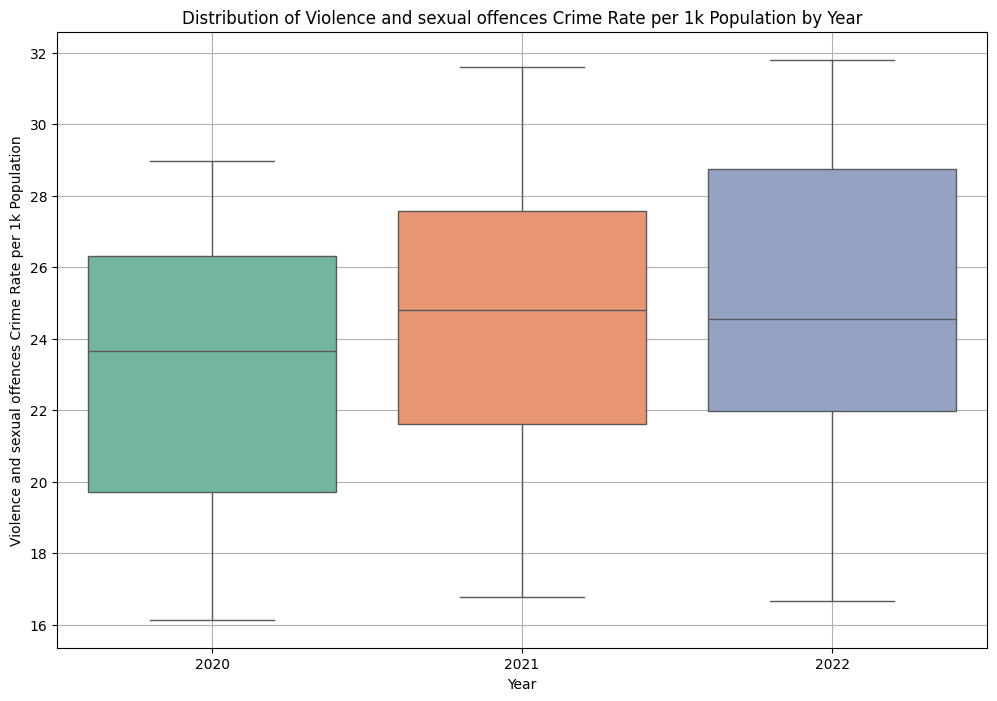

/var/folders/qy/0_d5tnf902v8gq6h02wv_gfc0000gn/T/ipykernel_21866/494227149.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_df['Employment Rate (%)'] = pd.to_numeric(crime_df['Employment Rate (%)'], errors='coerce')
/var/folders/qy/0_d5tnf902v8gq6h02wv_gfc0000gn/T/ipykernel_21866/494227149.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_df[f'{crime_type} Crime Rate per 1k population'] = pd.to_numeric(crime_df[f'{crime_type} Crime Rate per 1k population'], errors='coerce')



Correlation between Employment Rate and Burglary Crime Rate per 1k population by year:
year
2020   -0.146931
2021   -0.080851
2022   -0.264911
dtype: float64


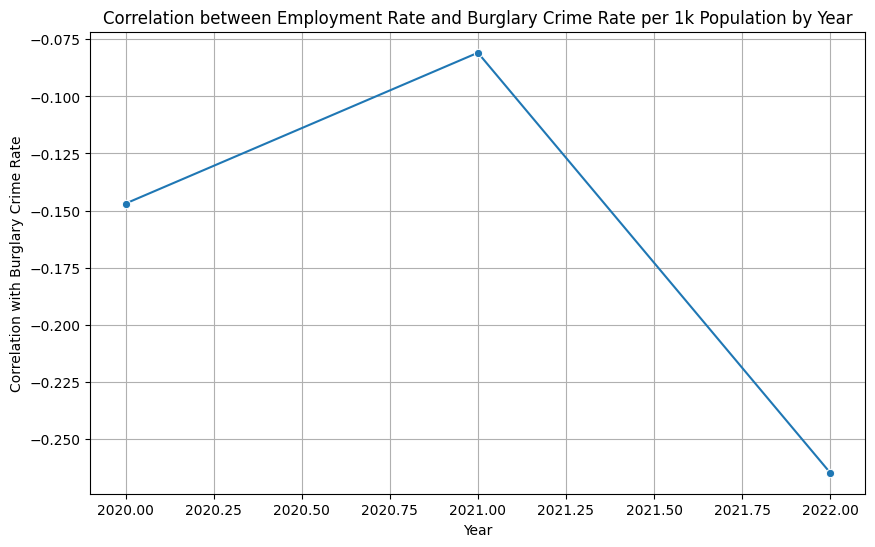

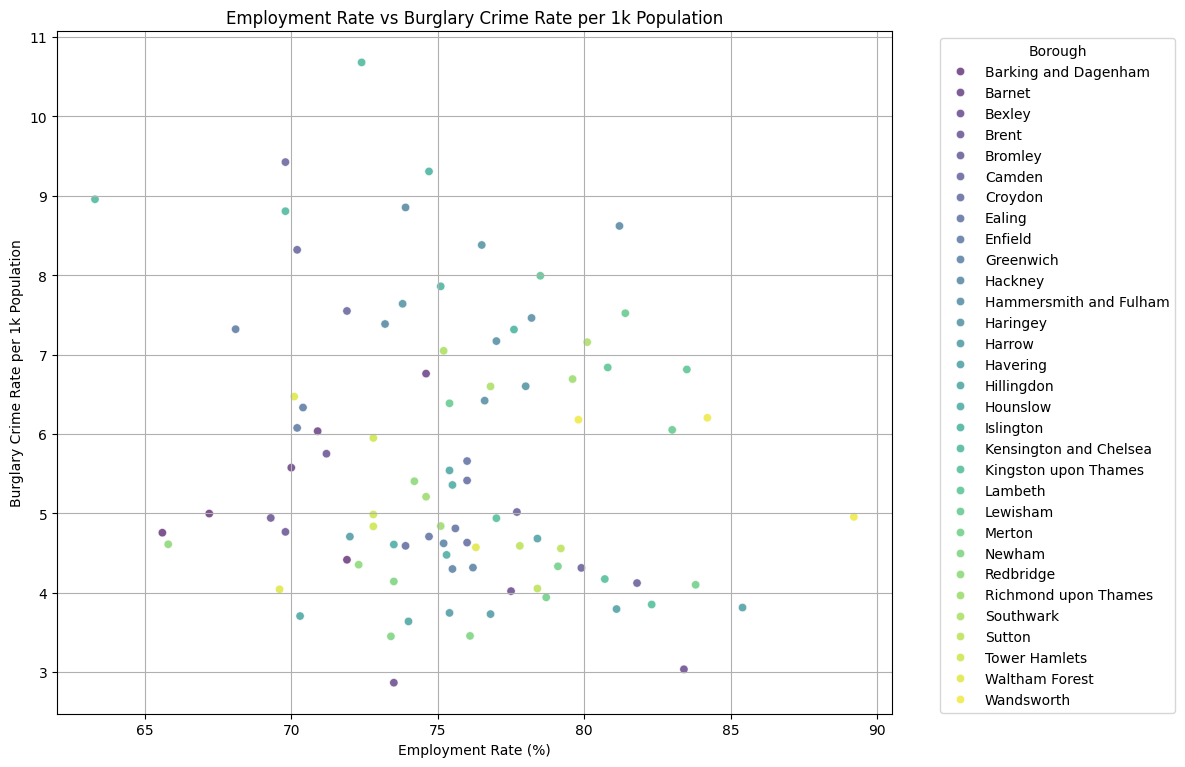

/var/folders/qy/0_d5tnf902v8gq6h02wv_gfc0000gn/T/ipykernel_21866/494227149.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


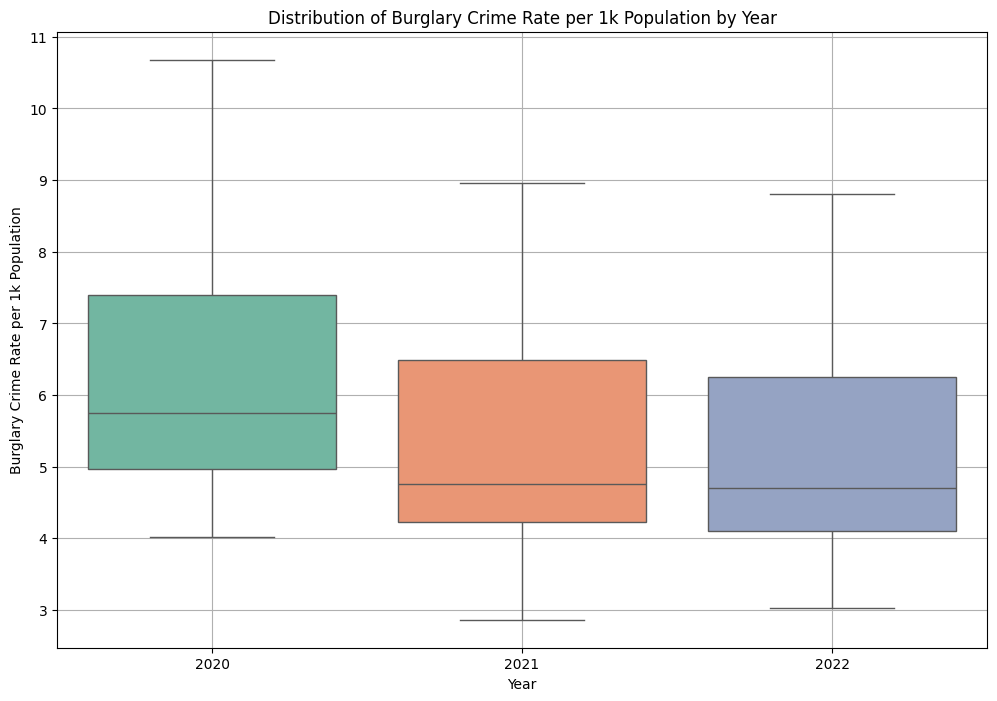

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to perform correlation analysis and visualization for a given dataframe by year
def correlation_analysis_by_year(crime_df, crime_type):
    # Ensure columns are numeric
    crime_df['Employment Rate (%)'] = pd.to_numeric(crime_df['Employment Rate (%)'], errors='coerce')
    crime_df[f'{crime_type} Crime Rate per 1k population'] = pd.to_numeric(crime_df[f'{crime_type} Crime Rate per 1k population'], errors='coerce')

    # Group by year and calculate correlation for each year
    correlation_by_year = crime_df.groupby('year').apply(
        lambda df: df[['Employment Rate (%)', f'{crime_type} Crime Rate per 1k population']].corr().iloc[0, 1]
    )

    print(f"\nCorrelation between Employment Rate and {crime_type} Crime Rate per 1k population by year:")
    print(correlation_by_year)

    # Visualize the correlation over years
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=correlation_by_year.index, y=correlation_by_year.values, marker='o')
    plt.title(f'Correlation between Employment Rate and {crime_type} Crime Rate per 1k Population by Year')
    plt.xlabel('Year')
    plt.ylabel(f'Correlation with {crime_type} Crime Rate')
    plt.grid(True)
    plt.show()
    
    # Scatter Plot: Employment Rate vs Crime Rate per 1k population
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(
        data=crime_df,
        x='Employment Rate (%)',
        y=f'{crime_type} Crime Rate per 1k population',
        hue='LAD22NM',  # Borough names for hue
        palette='viridis',
        legend='full',
        alpha=0.7
    )
    plt.title(f'Employment Rate vs {crime_type} Crime Rate per 1k Population')
    plt.xlabel('Employment Rate (%)')
    plt.ylabel(f'{crime_type} Crime Rate per 1k Population')
    plt.legend(title='Borough', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Box Plot: Crime Rate per 1k population by Year
    plt.figure(figsize=(12, 8))
    sns.boxplot(
        data=crime_df,
        x='year',
        y=f'{crime_type} Crime Rate per 1k population',
        palette='Set2'
    )
    plt.title(f'Distribution of {crime_type} Crime Rate per 1k Population by Year')
    plt.xlabel('Year')
    plt.ylabel(f'{crime_type} Crime Rate per 1k Population')
    plt.grid(True)
    plt.show()

# Remove 'City of London' from the dataset
antisocial_behaviour_df_filtered = antisocial_behaviour_df[
    ~antisocial_behaviour_df['LAD22NM'].isin(['City of London', 'Westminster'])]
violence_sexual_offences_df_filtered = violence_sexual_offences_df[
    ~violence_sexual_offences_df['LAD22NM'].isin(['City of London', 'Westminster'])]
burglary_df_filtered = burglary_df[
    ~burglary_df['LAD22NM'].isin(['City of London', 'Westminster'])]
# Perform correlation analysis and visualization without 'City of London'
correlation_analysis_by_year(antisocial_behaviour_df_filtered, 'Anti-social behaviour')
correlation_analysis_by_year(violence_sexual_offences_df_filtered, 'Violence and sexual offences')
correlation_analysis_by_year(burglary_df_filtered, 'Burglary')


In [18]:
#Exploratory Spatial Data Analysis (ESDA) GLOBAL MORAN'S I

import geopandas as gpd
import numpy as np
import pandas as pd
from esda.moran import Moran, Moran_Local
import matplotlib.pyplot as plt
import seaborn as sns
from pysal.lib import weights

KeyboardInterrupt: 

In [ ]:
import geopandas as gpd
import numpy as np
import pandas as pd
from esda.moran import Moran
import matplotlib.pyplot as plt
import seaborn as sns
from pysal.lib import weights

# Path to the shapefile
shapefile_path = '/Users/beckykassaye/Downloads/Local_Authority_Districts_May_2022_UK_BFE_V3_2022_3331011932393166417/LAD_MAY_2022_UK_BFE_V3.shp'
london_boroughs = gpd.read_file(shapefile_path)

def merge_and_calculate_morans_i(crime_df_filtered, crime_type):
    # Merge shapefile data with the crime data
    merged_gdf = london_boroughs.merge(crime_df_filtered, on='LAD22CD')

    # Ensure CRS is consistent
    merged_gdf = merged_gdf.to_crs(epsg=4326)

    # Remove 'City of London' and 'Westminster' from the data
    merged_gdf = merged_gdf[~merged_gdf['LAD22NM_x'].isin(['City of London', 'Westminster'])]

    # Fill any missing values in the crime rate columns with 0
    variable = f'{crime_type} Crime Rate per 1k population'
    merged_gdf[variable] = merged_gdf[variable].fillna(0)

    # Function to calculate Global Moran's I
    def calculate_global_morans_i(data, variable):
        w = weights.contiguity.Queen.from_dataframe(data, use_index=True)
        w.transform = 'r'
        moran = Moran(data[variable], w)
        return moran.I, moran.z_norm, moran.p_norm

    # Loop through each year and calculate Global Moran's I
    results = []
    for year in crime_df_filtered['year'].unique():
        yearly_gdf = merged_gdf[merged_gdf['year'] == year]
        
        # Calculate Global Moran's I for the specific crime type
        morans_i, z_score, p_value = calculate_global_morans_i(yearly_gdf, variable)
        results.append({'Year': year, 'Crime Type': crime_type, 'Moran\'s Index': morans_i, 'z-Score': z_score, 'p-Value': p_value})

    # Calculate Global Moran's I for the entire period
    morans_i, z_score, p_value = calculate_global_morans_i(merged_gdf, variable)
    results.append({'Year': 'Overall', 'Crime Type': crime_type, 'Moran\'s Index': morans_i, 'z-Score': z_score, 'p-Value': p_value})

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

# Run the analysis for each crime type and display the results
antisocial_behaviour_results = merge_and_calculate_morans_i(antisocial_behaviour_df_filtered, 'Anti-social behaviour')
violence_sexual_offences_results = merge_and_calculate_morans_i(violence_sexual_offences_df_filtered, 'Violence and sexual offences')
burglary_results = merge_and_calculate_morans_i(burglary_df_filtered, 'Burglary')


# Combine all the results into one DataFrame for easy comparison
combined_results = pd.concat([antisocial_behaviour_results, violence_sexual_offences_results, burglary_results], ignore_index=True)
print("\nCombined Moran's I results for all crime types:")
print(combined_results)

# You can further plot the results if needed



Combined Moran's I results for all crime types:
       Year                    Crime Type  Moran's Index    z-Score  \
0      2020         Anti-social behaviour       0.436153   4.206715   
1      2021         Anti-social behaviour       0.403096   3.910510   
2      2022         Anti-social behaviour       0.391390   3.805622   
3   Overall         Anti-social behaviour       0.259332   7.875335   
4      2020  Violence and sexual offences       0.100885   1.202626   
5      2021  Violence and sexual offences       0.148576   1.629955   
6      2022  Violence and sexual offences       0.172923   1.848103   
7   Overall  Violence and sexual offences       0.236690   7.215419   
8      2020                      Burglary       0.363094   3.552083   
9      2021                      Burglary       0.391360   3.805356   
10     2022                      Burglary       0.336457   3.313408   
11  Overall                      Burglary       0.407804  12.202731   

         p-Value  
0   2.59

In [ ]:
import geopandas as gpd
import numpy as np
import pandas as pd
from esda.moran import Moran
import matplotlib.pyplot as plt
import seaborn as sns
from pysal.lib import weights

# Load the shapefile
shapefile_path = '/Users/beckykassaye/Downloads/Local_Authority_Districts_May_2022_UK_BFE_V3_2022_3331011932393166417/LAD_MAY_2022_UK_BFE_V3.shp'
london_boroughs = gpd.read_file(shapefile_path)

# Function to merge employment data with the shapefile and calculate Moran's I for Employment Rate (%)
def merge_and_calculate_morans_i_employment(employment_df_filtered):
    # Merge shapefile data with the employment data
    merged_gdf = london_boroughs.merge(employment_df_filtered, on='LAD22CD')

    # Ensure CRS is consistent
    merged_gdf = merged_gdf.to_crs(epsg=4326)

    # Remove 'City of London' and 'Westminster' from the data
    merged_gdf = merged_gdf[~merged_gdf['LAD22NM_x'].isin(['City of London', 'Westminster'])]

    # Fill any missing values in the employment rate column with 0
    merged_gdf['Employment Rate (%)'] = merged_gdf['Employment Rate (%)'].fillna(0)

    # Function to calculate Global Moran's I
    def calculate_global_morans_i(data, variable):
        w = weights.contiguity.Queen.from_dataframe(data, use_index=True)
        w.transform = 'r'
        moran = Moran(data[variable], w)
        return moran.I, moran.z_norm, moran.p_norm

    # Loop through each year and calculate Global Moran's I for Employment Rate (%)
    results = []
    for year in employment_df_filtered['year'].unique():
        yearly_gdf = merged_gdf[merged_gdf['year'] == year]
        
        # Calculate Global Moran's I for Employment Rate (%)
        morans_i, z_score, p_value = calculate_global_morans_i(yearly_gdf, 'Employment Rate (%)')
        results.append({'Year': year, 'Variable': 'Employment Rate (%)', 'Moran\'s Index': morans_i, 'z-Score': z_score, 'p-Value': p_value})

    # Calculate Global Moran's I for the entire period
    morans_i, z_score, p_value = calculate_global_morans_i(merged_gdf, 'Employment Rate (%)')
    results.append({'Year': 'Overall', 'Variable': 'Employment Rate (%)', 'Moran\'s Index': morans_i, 'z-Score': z_score, 'p-Value': p_value})

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

# Run the analysis for employment rate and display the results
employment_results = merge_and_calculate_morans_i_employment(merged_df1)

# Display the results for Employment Rate (%)
print("Employment Rate (%) Global Moran's I results:")
print(employment_results)



Employment Rate (%) Global Moran's I results:
      Year             Variable  Moran's Index    z-Score        p-Value
0     2020  Employment Rate (%)       0.427439  12.774991   2.261731e-37
1     2021  Employment Rate (%)       0.228177   6.967293   3.230962e-12
2     2022  Employment Rate (%)       0.385372  11.548898   7.477341e-31
3  Overall  Employment Rate (%)       0.303165  27.501962  1.663287e-166


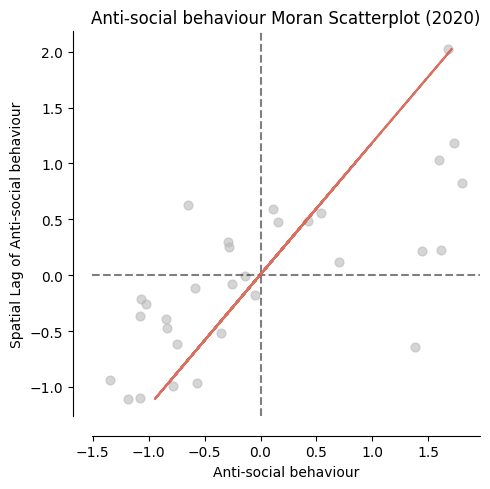

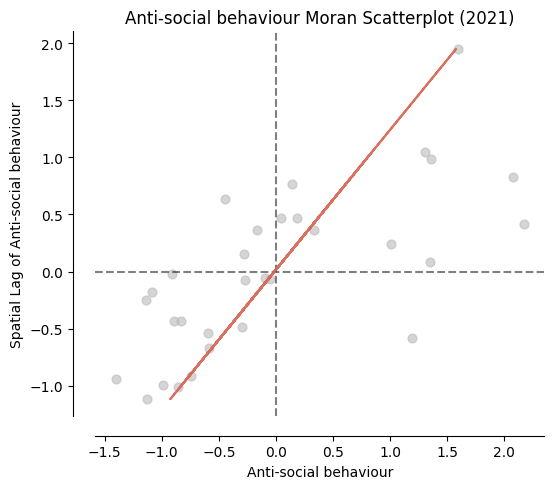

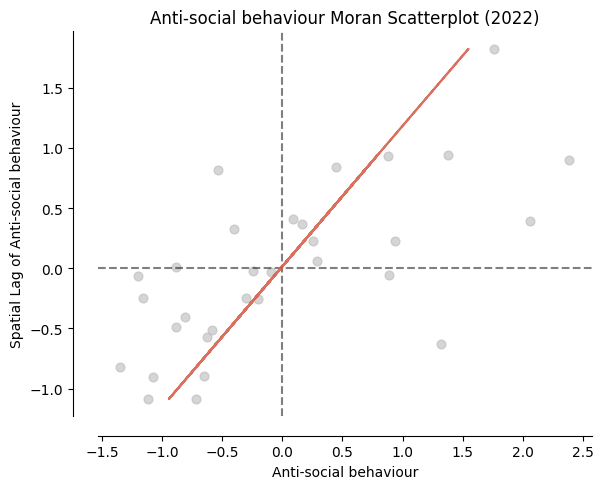

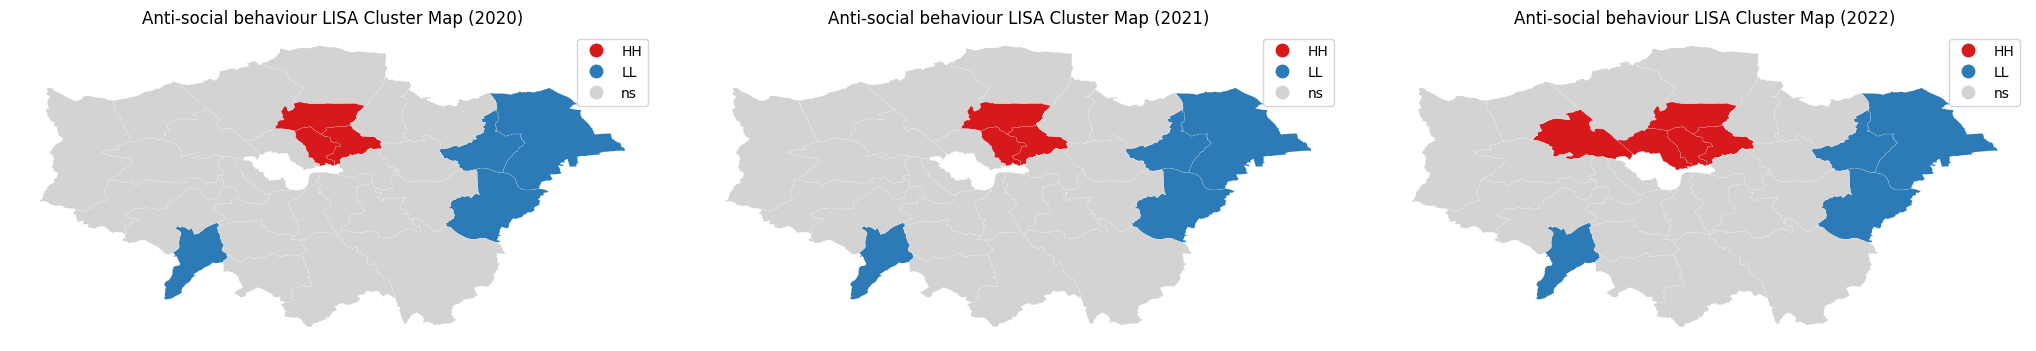

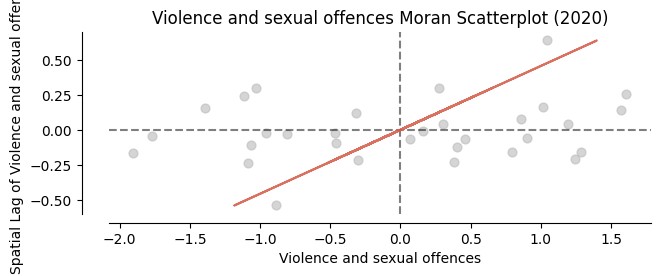

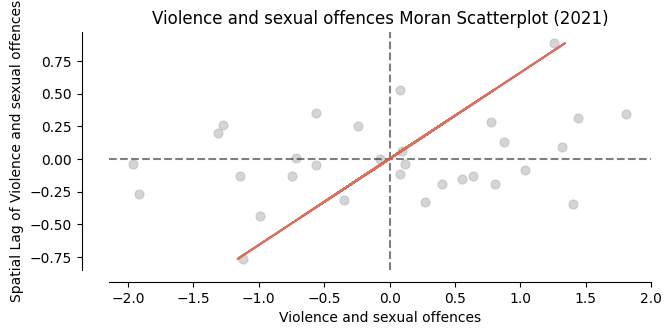

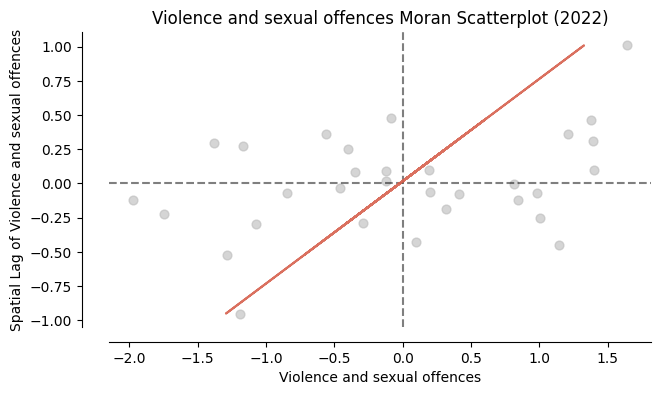

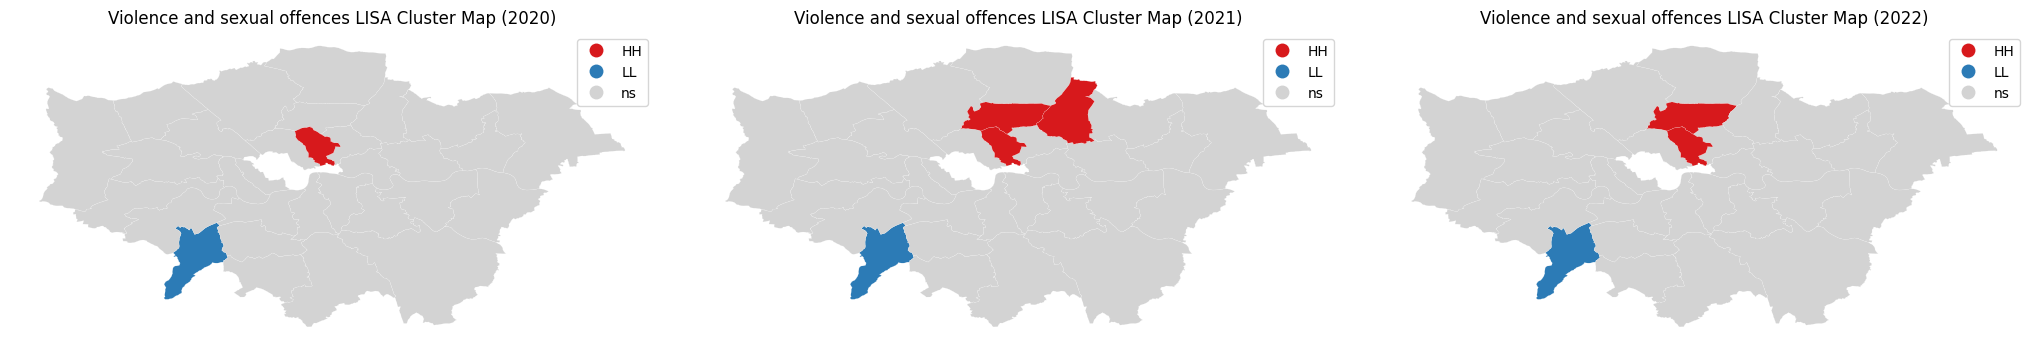

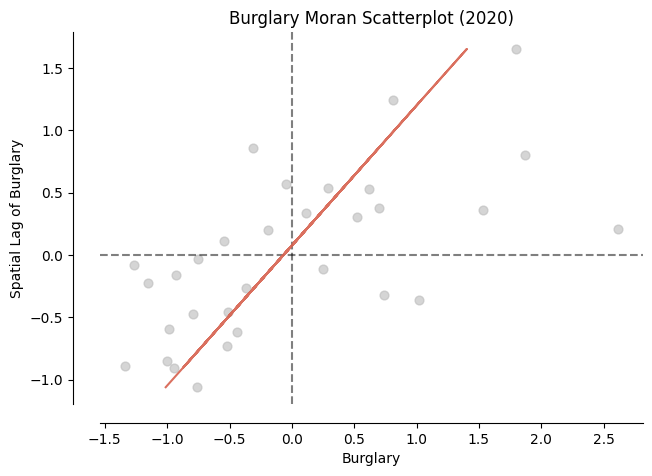

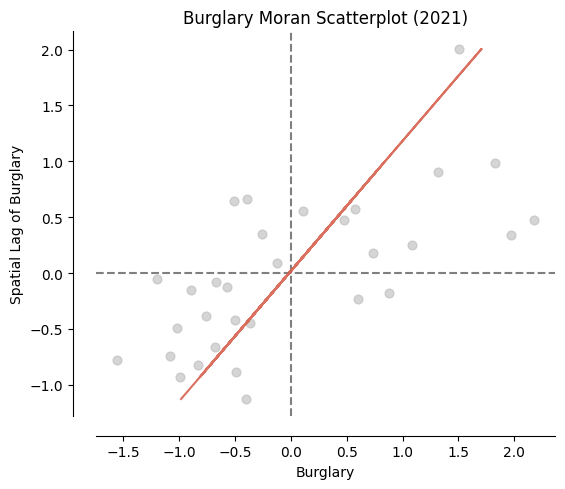

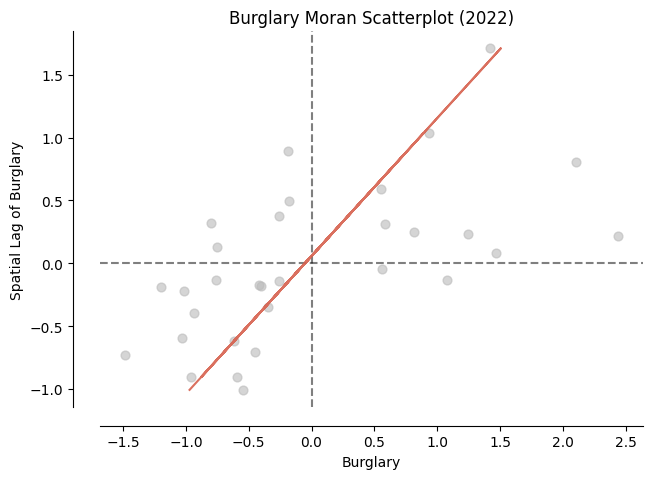

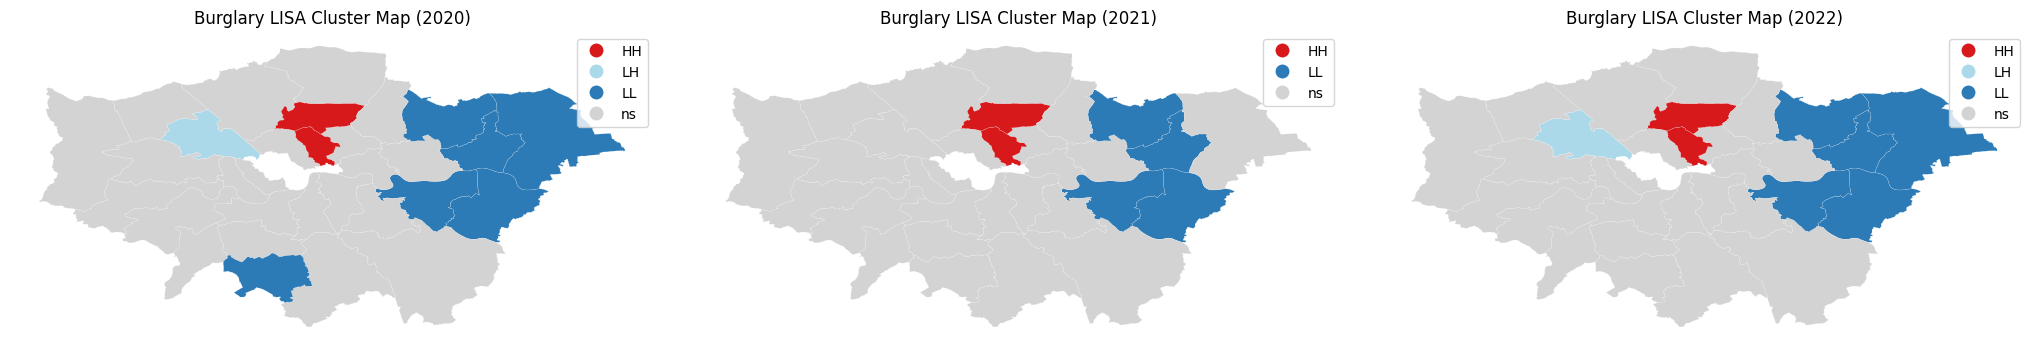

In [ ]:
#Exploratory Spatial Data Analysis (ESDA) LOCAL MORAN'S I

import numpy as np
import geopandas as gpd
import pandas as pd
import libpysal as lps
import matplotlib.pyplot as plt
from esda.moran import Moran_Local
from splot.esda import moran_scatterplot, lisa_cluster

# Load the shapefile
shapefile_path = '/Users/beckykassaye/Downloads/Local_Authority_Districts_May_2022_UK_BFE_V3_2022_3331011932393166417/LAD_MAY_2022_UK_BFE_V3.shp'
london_boroughs = gpd.read_file(shapefile_path)

# Function to merge with shapefile and convert to GeoDataFrame
def merge_with_shapefile(crime_df_filtered):
    # Merge shapefile data with the crime data
    merged_gdf = london_boroughs.merge(crime_df_filtered, on='LAD22CD')

    # Ensure CRS is consistent
    merged_gdf = merged_gdf.to_crs(epsg=4326)

    # Remove 'City of London' and 'Westminster' from the data
    merged_gdf = merged_gdf[~merged_gdf['LAD22NM_x'].isin(['City of London', 'Westminster'])]
    
    return merged_gdf

# Function to perform Local Moran's I analysis and plot scatterplots individually
def plot_individual_scatterplots(gdf, variable, title, years):
    for year in years:
        gdf_year = gdf[gdf['year'] == year]
        y = gdf_year[variable].values
        w = lps.weights.Queen.from_dataframe(gdf_year, use_index=True)
        w.transform = 'r'

        moran_loc = Moran_Local(y, w)

        # Plot Moran Scatterplot
        fig, ax = plt.subplots(figsize=(7, 5))
        moran_scatterplot(moran_loc, ax=ax)
        ax.set_xlabel(f'{title}')
        ax.set_ylabel(f'Spatial Lag of {title}')
        ax.set_title(f'{title} Moran Scatterplot ({year})')
        plt.show()

# Function to perform Local Moran's I and LISA Cluster Analysis, and plot LISA maps together
def plot_grouped_lisa_maps(gdf, variable, title, years):
    # Set up subplots for LISA cluster maps with larger figure size
    fig, axes = plt.subplots(1, len(years), figsize=(7 * len(years), 5))  # Increased figure size
    
    for i, year in enumerate(years):
        gdf_year = gdf[gdf['year'] == year]
        y = gdf_year[variable].values
        w = lps.weights.Queen.from_dataframe(gdf_year, use_index=True)
        w.transform = 'r'

        moran_loc = Moran_Local(y, w)

        # Plot LISA Cluster Map
        lisa_cluster(moran_loc, gdf_year, p=0.05, ax=axes[i])
        axes[i].set_title(f'{title} LISA Cluster Map ({year})')

    plt.tight_layout(pad=3.0)
    plt.show()

# Function to run Local Moran's I and LISA for each crime type dataframe
def run_local_morans_and_lisa(crime_df_filtered, crime_type):
    # List of years in the data
    years_to_analyze = crime_df_filtered['year'].unique()

    # Merge crime data with shapefile
    gdf = merge_with_shapefile(crime_df_filtered)

    # Set the appropriate variable for the crime type
    variable = f'{crime_type} Crime Rate per 1k population'
    
    # Perform Local Moran's I and plot individual scatterplots
    plot_individual_scatterplots(gdf, variable, crime_type, years_to_analyze)
    
    # Perform LISA cluster analysis and plot grouped LISA cluster maps
    plot_grouped_lisa_maps(gdf, variable, crime_type, years_to_analyze)

# For Anti-social behaviour
run_local_morans_and_lisa(antisocial_behaviour_df_filtered, 'Anti-social behaviour')

# For Violence and sexual offences
run_local_morans_and_lisa(violence_sexual_offences_df_filtered, 'Violence and sexual offences')

# For Burglary
run_local_morans_and_lisa(burglary_df_filtered, 'Burglary')


Bivariate Moran's I for Employment Rate vs Anti-social behaviour (2020): -0.1463
Bivariate Moran's I p-value for Employment Rate vs Anti-social behaviour (2020): 0.1480


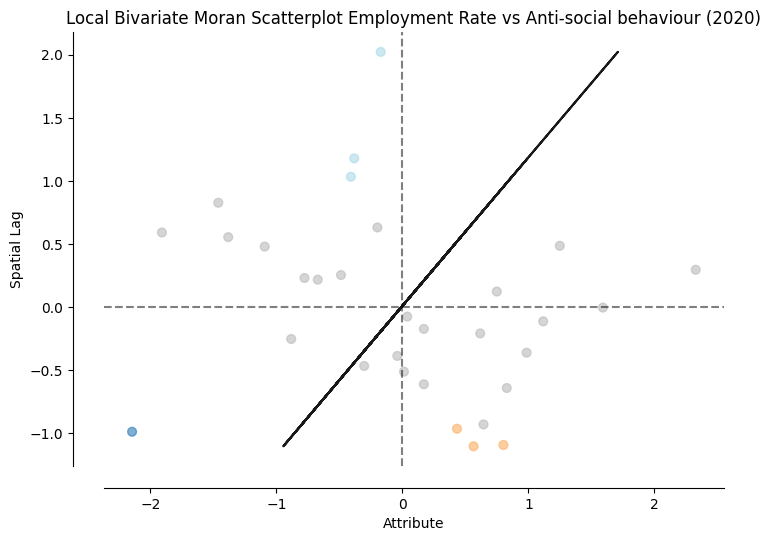

Bivariate Moran's I for Employment Rate vs Anti-social behaviour (2021): -0.0617
Bivariate Moran's I p-value for Employment Rate vs Anti-social behaviour (2021): 0.2940


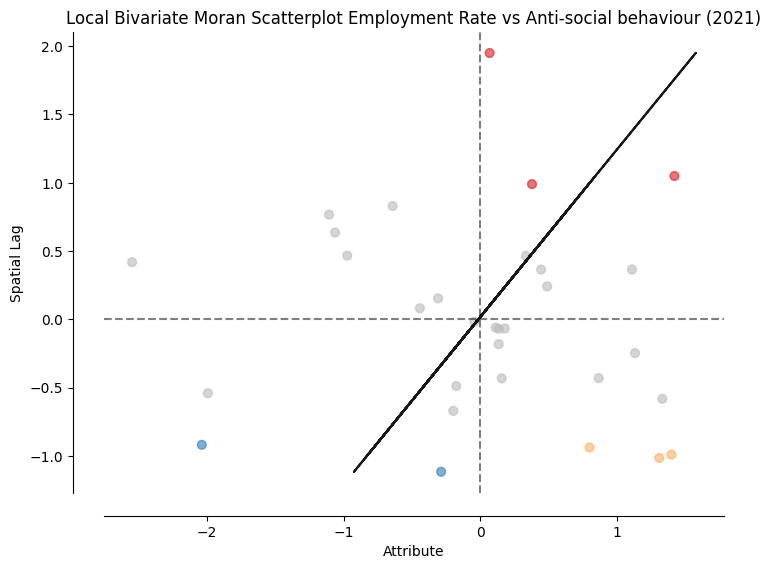

Bivariate Moran's I for Employment Rate vs Anti-social behaviour (2022): -0.2369
Bivariate Moran's I p-value for Employment Rate vs Anti-social behaviour (2022): 0.0230


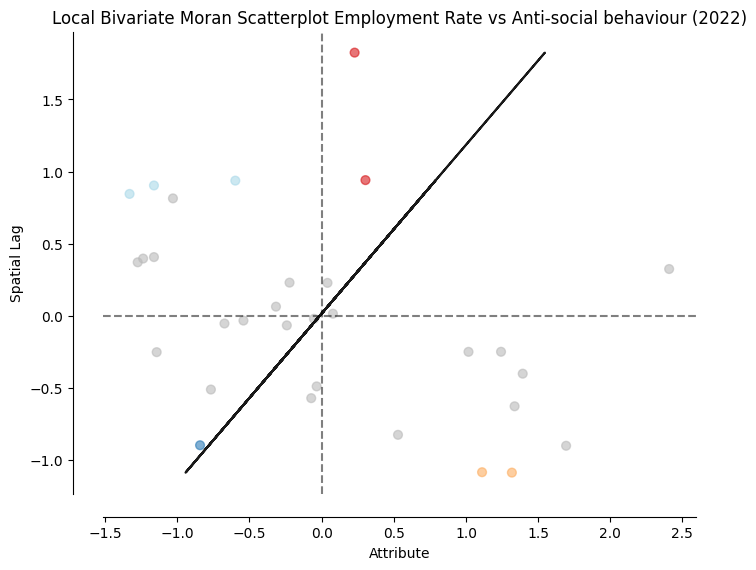

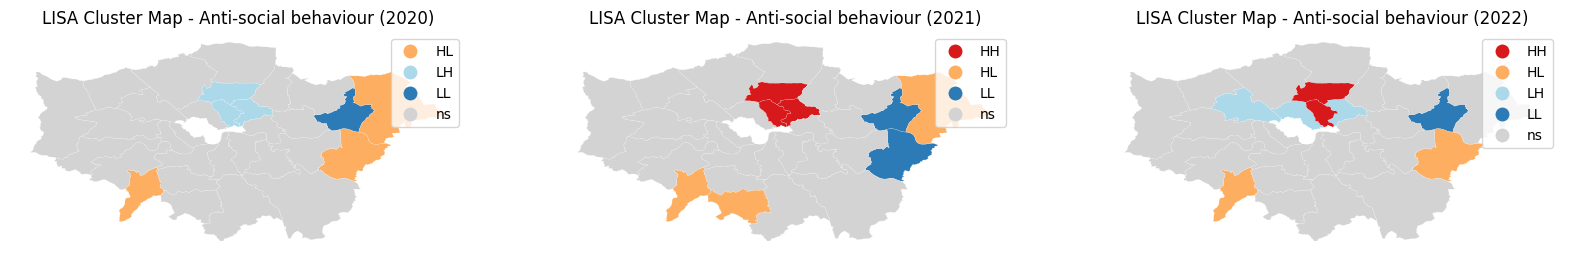

Bivariate Moran's I for Employment Rate vs Violence and sexual offences (2020): -0.1323
Bivariate Moran's I p-value for Employment Rate vs Violence and sexual offences (2020): 0.1570


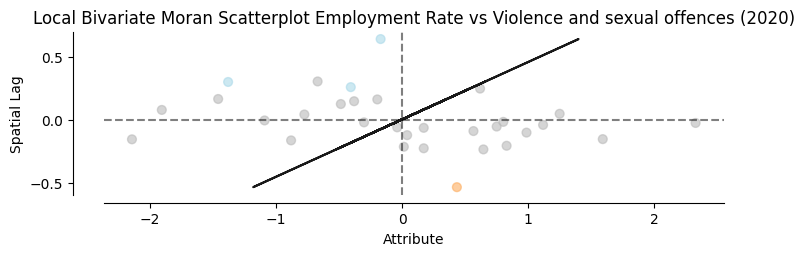

Bivariate Moran's I for Employment Rate vs Violence and sexual offences (2021): -0.0725
Bivariate Moran's I p-value for Employment Rate vs Violence and sexual offences (2021): 0.2050


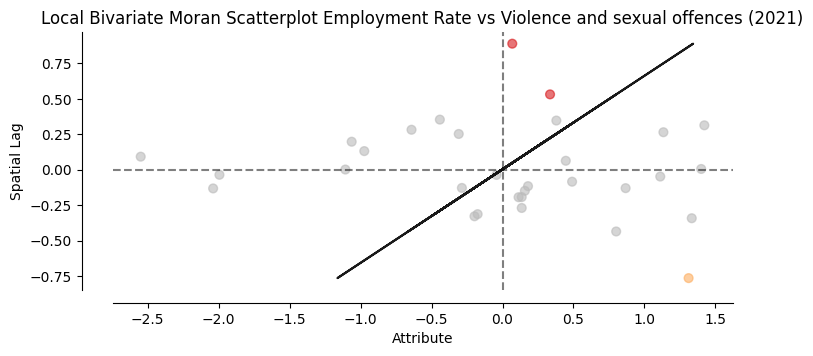

Bivariate Moran's I for Employment Rate vs Violence and sexual offences (2022): -0.1523
Bivariate Moran's I p-value for Employment Rate vs Violence and sexual offences (2022): 0.0880


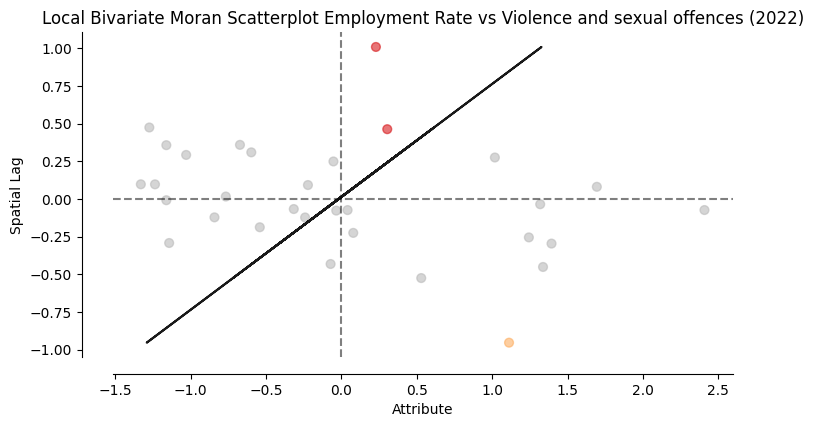

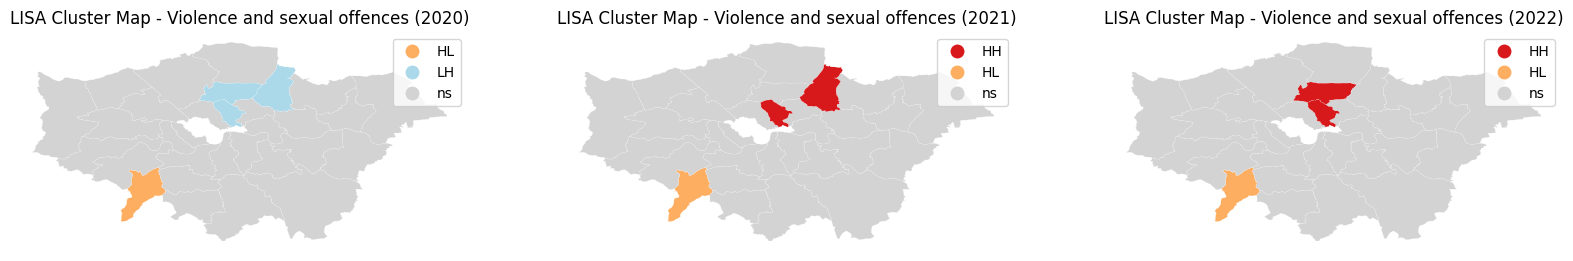

Bivariate Moran's I for Employment Rate vs Burglary (2020): -0.1007
Bivariate Moran's I p-value for Employment Rate vs Burglary (2020): 0.2240


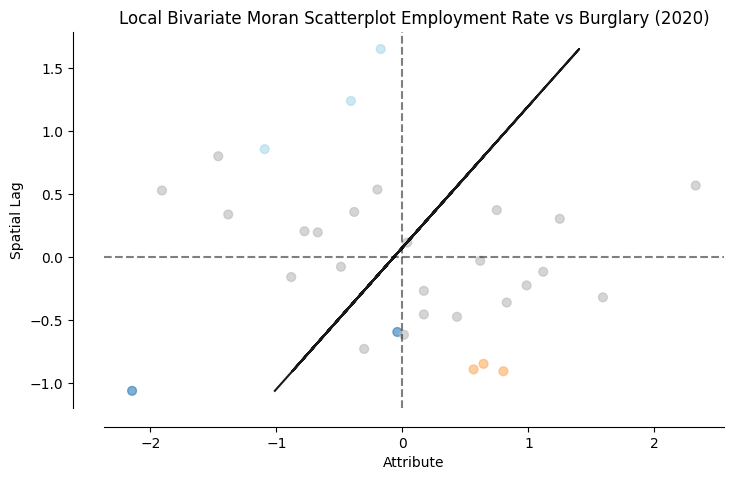

Bivariate Moran's I for Employment Rate vs Burglary (2021): -0.0162
Bivariate Moran's I p-value for Employment Rate vs Burglary (2021): 0.4100


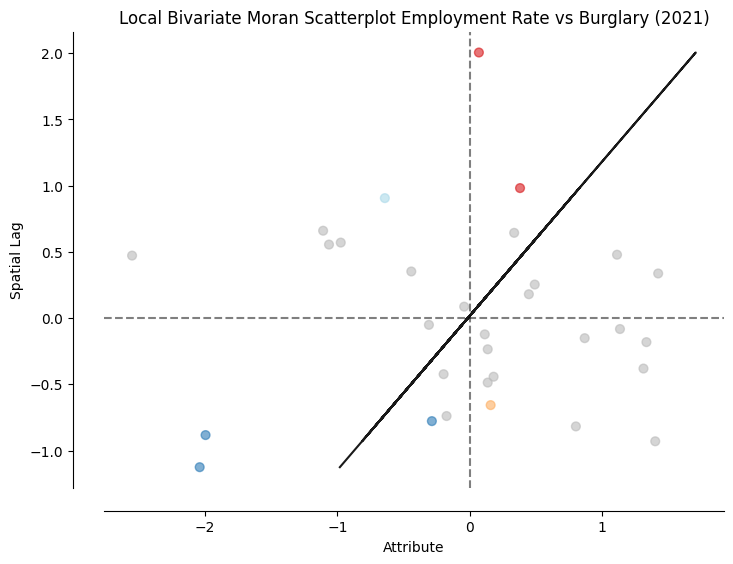

Bivariate Moran's I for Employment Rate vs Burglary (2022): -0.0981
Bivariate Moran's I p-value for Employment Rate vs Burglary (2022): 0.1850


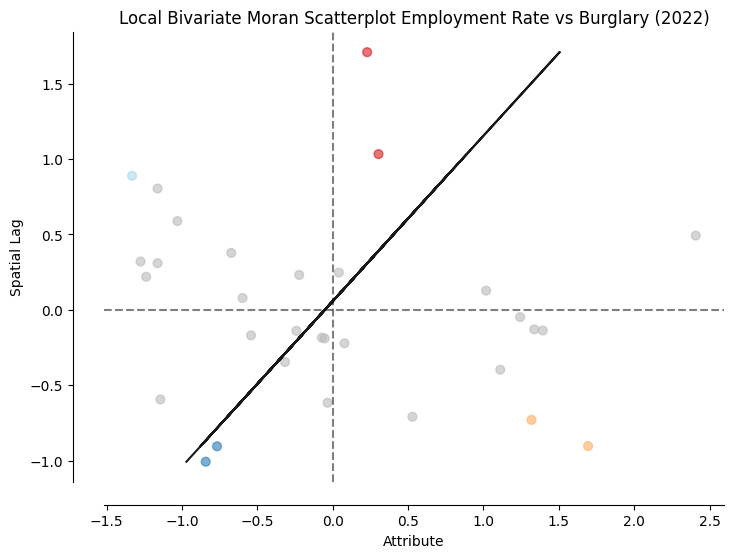

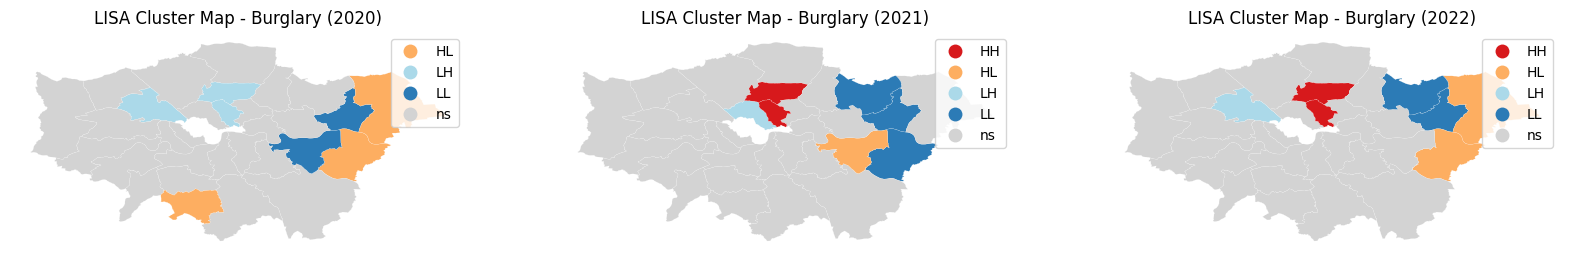

In [ ]:
# BIVARIATE MORAN'S I 
import numpy as np
import geopandas as gpd
import libpysal as lps
import matplotlib.pyplot as plt
from esda.moran import Moran_BV, Moran_Local_BV
from splot.esda import moran_scatterplot, lisa_cluster

employment_rate = 'Employment Rate (%)'

# Load the shapefile
shapefile_path = '/Users/beckykassaye/Downloads/Local_Authority_Districts_May_2022_UK_BFE_V3_2022_3331011932393166417/LAD_MAY_2022_UK_BFE_V3.shp'
london_boroughs = gpd.read_file(shapefile_path)

# Function to merge crime data with the shapefile 
def merge_with_shapefile(crime_df_filtered):
    # Merge shapefile data with the crime data
    merged_gdf = london_boroughs.merge(crime_df_filtered, on='LAD22CD')

    # Ensure CRS is consistent
    merged_gdf = merged_gdf.to_crs(epsg=4326)

    # Remove 'City of London' and 'Westminster' from the data
    merged_gdf = merged_gdf[~merged_gdf['LAD22NM_x'].isin(['City of London', 'Westminster'])]
    
    return merged_gdf

# Function to perform Bivariate Moran’s I analysis and plot results
def bivariate_morans_i_analysis(gdf, x_var, y_var, title_suffix):
    # Extract the variables
    x = gdf[x_var].values
    y = gdf[y_var].values

    # Define spatial weights
    w = lps.weights.Queen.from_dataframe(gdf, use_index=True)
    w.transform = 'r'

    # Calculate Bivariate Moran's I
    moran_bv = Moran_BV(x, y, w)
    moran_loc_bv = Moran_Local_BV(x, y, w)

    # Print Bivariate Moran's I value and p-value
    print(f"Bivariate Moran's I for {title_suffix}: {moran_bv.I:.4f}")
    print(f"Bivariate Moran's I p-value for {title_suffix}: {moran_bv.p_sim:.4f}")

    # Create scatterplot for Local Bivariate Moran's I
    fig, ax = plt.subplots(figsize=(8, 6))
    moran_scatterplot(moran_loc_bv, p=0.05, ax=ax)
    ax.set_title(f'Local Bivariate Moran Scatterplot {title_suffix}')
    plt.show()

    return moran_loc_bv

# Function to plot LISA cluster maps
def plot_lisa_cluster_maps(gdf, moran_loc_bv_dict, crime_type):
    fig, axs = plt.subplots(1, len(moran_loc_bv_dict), figsize=(20, 8))
    for i, (year, moran_loc_bv) in enumerate(moran_loc_bv_dict.items()):
        lisa_cluster(moran_loc_bv, gdf[gdf['year'] == year], p=0.05, ax=axs[i])
        axs[i].set_title(f'LISA Cluster Map - {crime_type} ({year})')
    plt.show()

# Function to run Bivariate Moran’s I and LISA for each crime type dataframe
def run_bivariate_morans_and_lisa(crime_df_filtered, crime_type):
    # Define the list of years in the data
    years_to_analyze = crime_df_filtered['year'].unique()

    # Merge crime data with shapefile (create GeoDataFrame)
    gdf = merge_with_shapefile(crime_df_filtered)

    # Set up dictionary to store the Local Bivariate Moran’s I results for each year
    moran_loc_bv_dict = {}

    # Perform Bivariate Moran’s I for each year and store the results
    for year in years_to_analyze:
        yearly_gdf = gdf[gdf['year'] == year]
        title_suffix = f'Employment Rate vs {crime_type} ({year})'
        moran_loc_bv = bivariate_morans_i_analysis(yearly_gdf, employment_rate, f'{crime_type} Crime Rate per 1k population', title_suffix)
        moran_loc_bv_dict[year] = moran_loc_bv

    # Plot all LISA cluster maps for this crime type
    plot_lisa_cluster_maps(gdf, moran_loc_bv_dict, crime_type)

# For Anti-social behaviour
run_bivariate_morans_and_lisa(antisocial_behaviour_df_filtered, 'Anti-social behaviour')

# For Violence and sexual offences
run_bivariate_morans_and_lisa(violence_sexual_offences_df_filtered, 'Violence and sexual offences')

# For Burglary
run_bivariate_morans_and_lisa(burglary_df_filtered, 'Burglary')


In [ ]:
# REGRESSION ANALYSIS - OLS regression model

import statsmodels.api as sm
import pandas as pd

# Function to perform OLS regression for each year
def perform_ols_regression_per_year(crime_df, crime_type_column, independent_var):
    # Ensure columns are numeric using .loc to avoid SettingWithCopyWarning
    crime_df.loc[:, independent_var] = pd.to_numeric(crime_df[independent_var], errors='coerce')
    crime_df.loc[:, crime_type_column] = pd.to_numeric(crime_df[crime_type_column], errors='coerce')

    # Loop through each year and perform OLS regression
    for year in crime_df['year'].unique():
        yearly_df = crime_df[crime_df['year'] == year]

        # Prepare the independent variables (X) and dependent variable (y)
        X = yearly_df[[independent_var]]  # Independent variable
        X = sm.add_constant(X)  # Add a constant term to the predictors
        y = yearly_df[crime_type_column]  # Dependent variable

        # Check if there are enough observations for OLS (must be > 1)
        if len(yearly_df) > 1:
            # Fit the OLS model
            model = sm.OLS(y, X).fit()

            # Print the summary of the regression results
            print(f"\nOLS Regression Results for {crime_type_column} in year {year}:")
            print(model.summary())

# For Anti-social behaviour
perform_ols_regression_per_year(
    antisocial_behaviour_df_filtered,
    'Anti-social behaviour Crime Rate per 1k population',
    'Employment Rate (%)'
)

# For Violence and sexual offences
perform_ols_regression_per_year(
    violence_sexual_offences_df_filtered,
    'Violence and sexual offences Crime Rate per 1k population',
    'Employment Rate (%)'
)

# For Burglary
perform_ols_regression_per_year(
    burglary_df_filtered,
    'Burglary Crime Rate per 1k population',
    'Employment Rate (%)'
)


OLS Regression Results for Anti-social behaviour Crime Rate per 1k population in year 2020:
                                            OLS Regression Results                                            
Dep. Variable:     Anti-social behaviour Crime Rate per 1k population   R-squared:                       0.072
Model:                                                            OLS   Adj. R-squared:                  0.040
Method:                                                 Least Squares   F-statistic:                     2.259
Date:                                                Wed, 04 Sep 2024   Prob (F-statistic):              0.144
Time:                                                        22:35:23   Log-Likelihood:                -116.36
No. Observations:                                                  31   AIC:                             236.7
Df Residuals:                                                      29   BIC:                             239.6
Df Model:          

Optimal bandwidth for Anti-social behaviour Crime Rate per 1k population: 49.0
GWR Results for Anti-social behaviour Crime Rate per 1k population (2020-2022 combined):
        Intercept  Employment Rate (%)
count   93.000000            93.000000
mean    65.506242            -0.399649
std     26.878115             0.353747
min      0.464986            -0.960349
25%     54.876189            -0.700724
50%     67.435074            -0.420973
75%     84.679659            -0.339496
max    110.952735             0.510198


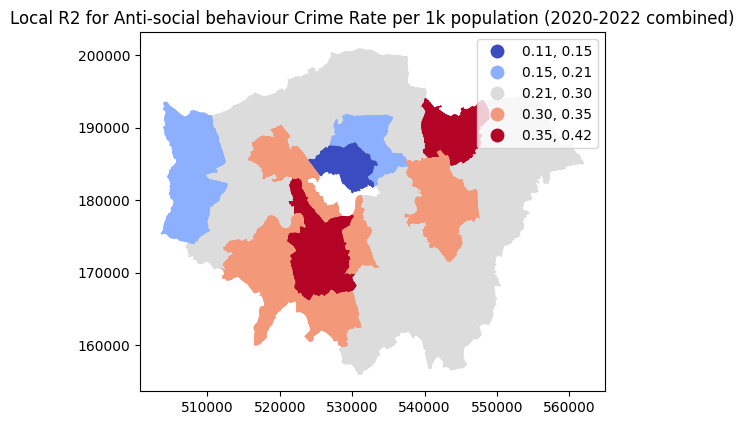

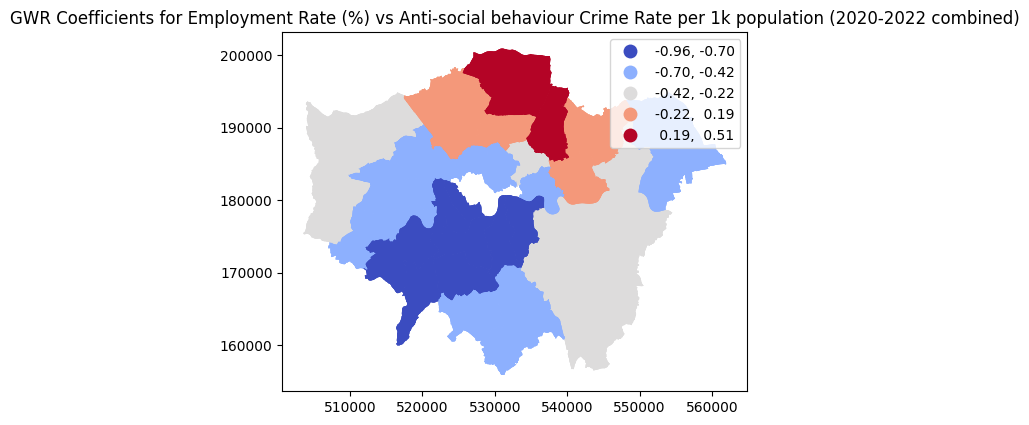

Optimal bandwidth for Violence and sexual offences Crime Rate per 1k population: 49.0
GWR Results for Violence and sexual offences Crime Rate per 1k population (2020-2022 combined):
       Intercept  Employment Rate (%)
count  93.000000            93.000000
mean   29.576887            -0.060464
std    16.829669             0.236616
min     0.358371            -0.372626
25%    14.529557            -0.276464
50%    33.785270            -0.125917
75%    45.495416             0.169651
max    51.464316             0.360548


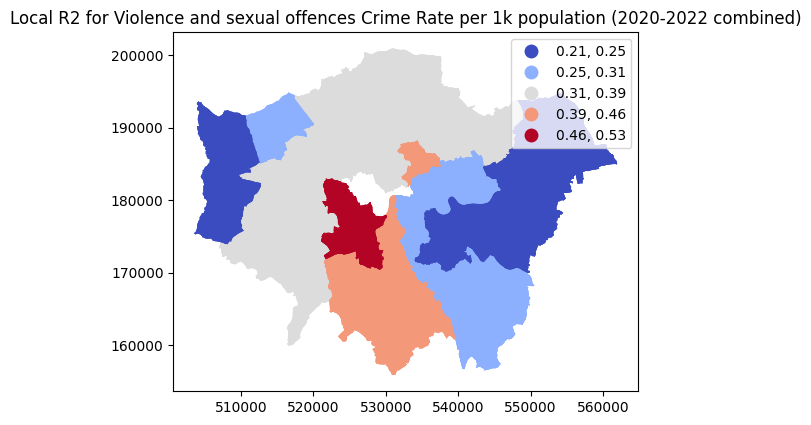

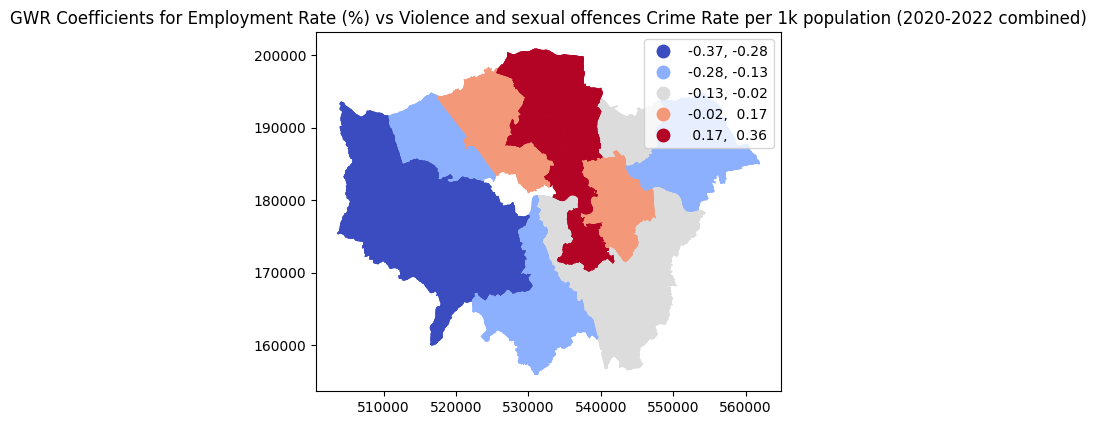

Optimal bandwidth for Burglary Crime Rate per 1k population: 49.0
GWR Results for Burglary Crime Rate per 1k population (2020-2022 combined):
       Intercept  Employment Rate (%)
count  93.000000            93.000000
mean    8.298514            -0.029758
std     6.754615             0.087323
min    -3.750655            -0.189344
25%     1.580833            -0.094055
50%     9.142590            -0.039603
75%    13.186356             0.069040
max    21.317873             0.135893


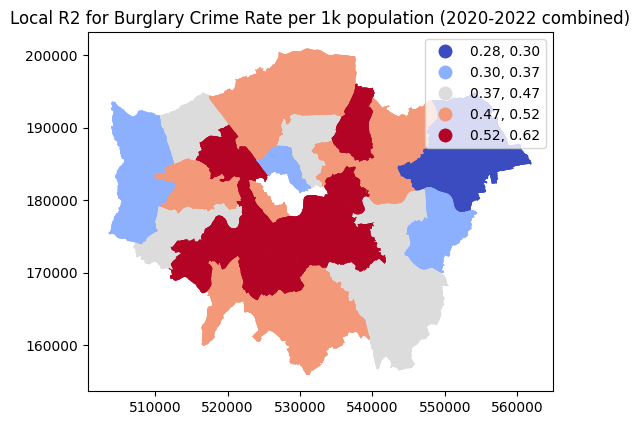

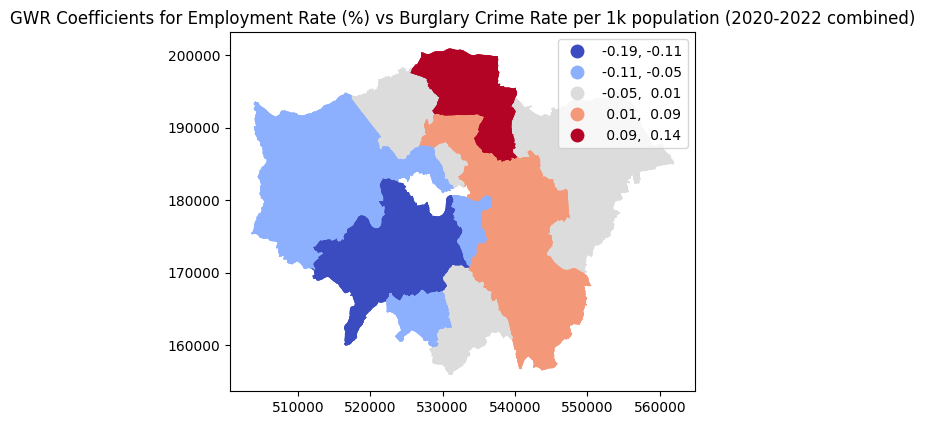

In [ ]:
# REGRESSION ANALYSIS - GWR regression model

import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import matplotlib.pyplot as plt

# Function to prepare the data and run GWR on combined data (2020-2022)
def perform_gwr_analysis_combined(gdf, crime_type_column, independent_var):
    # Ensure columns are numeric
    gdf[independent_var] = pd.to_numeric(gdf[independent_var], errors='coerce')
    gdf[crime_type_column] = pd.to_numeric(gdf[crime_type_column], errors='coerce')

    # Reproject to a projected CRS (e.g., British National Grid - EPSG: 27700) for distance calculations
    if gdf.crs.is_geographic:
        gdf = gdf.to_crs(epsg=27700)

    # Prepare coordinates for GWR (using centroids of geometries)
    coords = np.array(list(gdf.geometry.centroid.apply(lambda geom: (geom.x, geom.y))))

    # Prepare the independent variables (X) and dependent variable (y)
    X = gdf[[independent_var]].values  # Independent variable: Employment Rate
    y = gdf[crime_type_column].values.reshape(-1, 1)  # Dependent variable: Crime Rate

    # Add a constant term to the predictors
    X = sm.add_constant(X)

    # Select bandwidth using cross-validation (AICc criterion)
    gwr_selector = Sel_BW(coords, y, X)
    gwr_bw = gwr_selector.search()
    print(f"Optimal bandwidth for {crime_type_column}: {gwr_bw}")

    # Fit the GWR model with the selected bandwidth
    gwr_model = GWR(coords, y, X, gwr_bw)
    gwr_results = gwr_model.fit()

    # Print the GWR results summary (coefficients and other details)
    params = pd.DataFrame(gwr_results.params, columns=['Intercept', independent_var])
    print(f"GWR Results for {crime_type_column} (2020-2022 combined):")
    print(params.describe())

    # Add R2 to GeoDataFrame
    gdf['gwr_R2'] = gwr_results.localR2

    # Plot Local R2
    fig, ax = plt.subplots(figsize=(6, 6))
    gdf.plot(column='gwr_R2', cmap='coolwarm', linewidth=0.01, scheme='FisherJenks', k=5, legend=True, ax=ax)
    ax.set_title(f'Local R2 for {crime_type_column} (2020-2022 combined)')
    plt.show()

    # Add GWR coefficients to GeoDataFrame
    gdf['gwr_coeff'] = gwr_results.params[:, 1]

    # Plot GWR coefficients for the independent variable
    fig, ax = plt.subplots(figsize=(6, 6))
    gdf.plot(column='gwr_coeff', cmap='coolwarm', linewidth=0.01, scheme='FisherJenks', k=5, legend=True, ax=ax)
    ax.set_title(f'GWR Coefficients for {independent_var} vs {crime_type_column} (2020-2022 combined)')
    plt.show()

# Merge your crime data with the shapefile to create a combined GeoDataFrame
def merge_with_shapefile(crime_df, shapefile):
    merged_gdf = shapefile.merge(crime_df, on='LAD22CD')
    merged_gdf = merged_gdf.to_crs(epsg=4326)  # Ensure CRS is consistent
    merged_gdf = merged_gdf[~merged_gdf['LAD22NM_x'].isin(['City of London', 'Westminster'])]  # Remove outliers
    return merged_gdf

# Load your shapefile containing borough geometries
shapefile_path = '/Users/beckykassaye/Downloads/Local_Authority_Districts_May_2022_UK_BFE_V3_2022_3331011932393166417/LAD_MAY_2022_UK_BFE_V3.shp'
london_boroughs = gpd.read_file(shapefile_path)

# Combine data for all three years (2020, 2021, 2022) into one GeoDataFrame for each crime type

# 1. For Anti-social behaviour Crime Rate
antisocial_behaviour_gdf = merge_with_shapefile(antisocial_behaviour_df_filtered, london_boroughs)
perform_gwr_analysis_combined(antisocial_behaviour_gdf, 
                              'Anti-social behaviour Crime Rate per 1k population', 
                              'Employment Rate (%)')

# 2. For Violence and sexual offences Crime Rate
violence_sexual_offences_gdf = merge_with_shapefile(violence_sexual_offences_df_filtered, london_boroughs)
perform_gwr_analysis_combined(violence_sexual_offences_gdf, 
                              'Violence and sexual offences Crime Rate per 1k population', 
                              'Employment Rate (%)')

# 3. For Burglary Crime Rate
burglary_gdf = merge_with_shapefile(burglary_df_filtered, london_boroughs)
perform_gwr_analysis_combined(burglary_gdf, 
                              'Burglary Crime Rate per 1k population', 
                              'Employment Rate (%)')


In [ ]:
# Descriptive statistics 
import pandas as pd

# List of dataframes for each crime type
crime_dfs = {
    'Anti-social behaviour': antisocial_behaviour_df_filtered,
    'Violence and sexual offences': violence_sexual_offences_df_filtered,
    'Burglary': burglary_df_filtered
}

# List of crime and employment columns to analyze
crime_columns = {
    'Anti-social behaviour': 'Anti-social behaviour Crime Rate per 1k population',
    'Violence and sexual offences': 'Violence and sexual offences Crime Rate per 1k population',
    'Burglary': 'Burglary Crime Rate per 1k population'
}

employment_column = 'Employment Rate (%)'

# Function to calculate descriptive statistics for each year
def descriptive_stats_by_year(df, crime_column, employment_column):
    return df.groupby('year')[[crime_column, employment_column]].describe()

# Loop through each crime dataframe and print descriptive statistics for each year
for crime_type, df in crime_dfs.items():
    print(f"\nDescriptive Statistics for {crime_type} by Year:")
    crime_column = crime_columns[crime_type]
    print(descriptive_stats_by_year(df, crime_column, employment_column))

print("\nDescriptive Statistics for Employment Rate across all data:")
for crime_type, df in crime_dfs.items():
    print(f"\nEmployment Rate Statistics for {crime_type}:")
    print(df.groupby('year')[employment_column].describe())



Descriptive Statistics for Anti-social behaviour by Year:
     Anti-social behaviour Crime Rate per 1k population                        \
                                                  count       mean        std   
year                                                                            
2020                                               31.0  42.313796  10.898999   
2021                                               31.0  30.472861   8.389248   
2022                                               31.0  25.538590   7.053639   

                                                             \
            min        25%        50%        75%        max   
year                                                          
2020  27.873918  33.604900  39.250512  48.953570  61.651280   
2021  18.890471  23.501805  28.266918  36.002095  48.407844   
2022  16.176870  20.229818  23.862036  30.130614  42.100629   

     Employment Rate (%)                                                   

/var/folders/qy/0_d5tnf902v8gq6h02wv_gfc0000gn/T/ipykernel_1023/1008376051.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_df[crime_column] = pd.to_numeric(crime_df[crime_column], errors='coerce')
/var/folders/qy/0_d5tnf902v8gq6h02wv_gfc0000gn/T/ipykernel_1023/1008376051.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_df['Employment Rate (%)'] = pd.to_numeric(crime_df['Employment Rate (%)'], errors='coerce')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-package

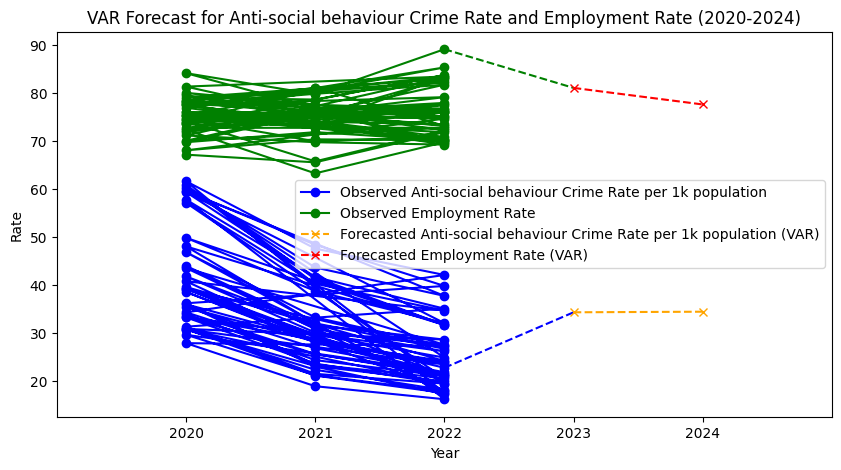

/var/folders/qy/0_d5tnf902v8gq6h02wv_gfc0000gn/T/ipykernel_1023/1008376051.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_df[crime_column] = pd.to_numeric(crime_df[crime_column], errors='coerce')
/var/folders/qy/0_d5tnf902v8gq6h02wv_gfc0000gn/T/ipykernel_1023/1008376051.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_df['Employment Rate (%)'] = pd.to_numeric(crime_df['Employment Rate (%)'], errors='coerce')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-package

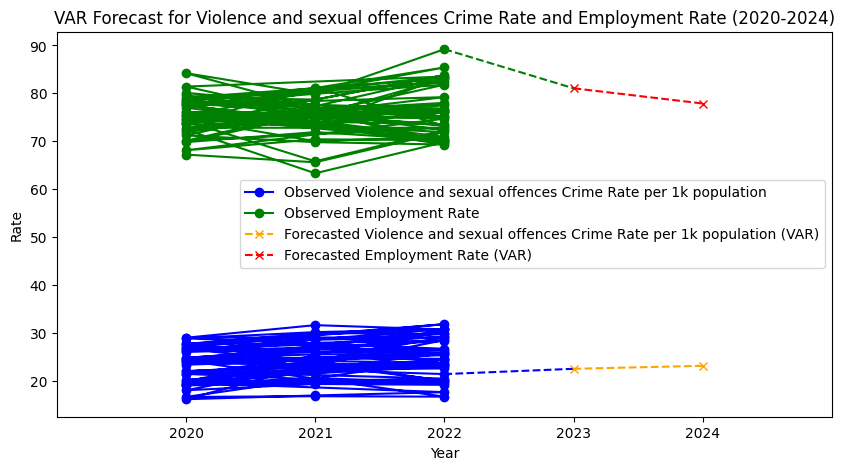

/var/folders/qy/0_d5tnf902v8gq6h02wv_gfc0000gn/T/ipykernel_1023/1008376051.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_df[crime_column] = pd.to_numeric(crime_df[crime_column], errors='coerce')
/var/folders/qy/0_d5tnf902v8gq6h02wv_gfc0000gn/T/ipykernel_1023/1008376051.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_df['Employment Rate (%)'] = pd.to_numeric(crime_df['Employment Rate (%)'], errors='coerce')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-package

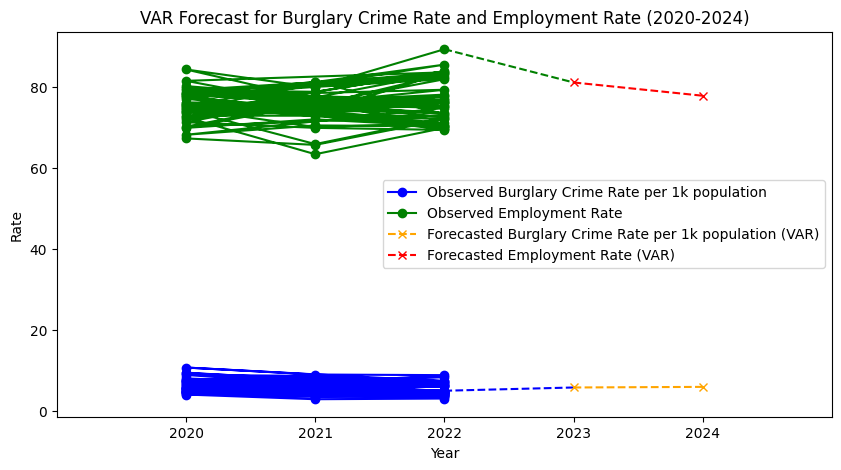

In [ ]:
# Time Series Forecasting - VAR model 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

# Define a function for performing VAR and plotting for a given crime type
def perform_var_and_plot(crime_df, crime_column, title):
    # Ensure the relevant columns are numeric
    crime_df[crime_column] = pd.to_numeric(crime_df[crime_column], errors='coerce')
    crime_df['Employment Rate (%)'] = pd.to_numeric(crime_df['Employment Rate (%)'], errors='coerce')

    # Filter for years 2020 to 2022 and remove any NaN values to avoid errors
    crime_df = crime_df[crime_df['year'].isin([2020, 2021, 2022])].dropna(subset=[crime_column, 'Employment Rate (%)'])
    crime_df.set_index('year', inplace=True)

    # Fit VAR model only on the crime rate and employment rate columns
    model = VAR(crime_df[[crime_column, 'Employment Rate (%)']])
    model_fitted = model.fit()

    # Forecast the next 2 years (2023 and 2024)
    lag_order = model_fitted.k_ar
    forecast_input = crime_df[[crime_column, 'Employment Rate (%)']].values[-lag_order:]  # Ensure correct shape
    forecasted_values = model_fitted.forecast(y=forecast_input, steps=2)

    # Create forecast DataFrame
    forecast_years = [2023, 2024]
    forecast_df = pd.DataFrame(forecasted_values, index=forecast_years, 
                               columns=[f'{crime_column} Forecast', 'Employment Rate Forecast'])

    # Combine observed and forecasted data for plotting
    combined_years = crime_df.index.tolist() + forecast_years
    combined_crime_rates = crime_df[crime_column].tolist() + forecast_df[f'{crime_column} Forecast'].tolist()
    combined_employment_rates = crime_df['Employment Rate (%)'].tolist() + forecast_df['Employment Rate Forecast'].tolist()

    # Plot observed and forecasted values
    plt.figure(figsize=(10, 5))

    # Plot observed data with solid lines
    plt.plot(crime_df.index, crime_df[crime_column], label=f'Observed {crime_column}', color='blue', marker='o')
    plt.plot(crime_df.index, crime_df['Employment Rate (%)'], label='Observed Employment Rate', color='green', marker='o')

    # Connect the last observed point (2022) to the first forecasted point (2023)
    plt.plot([2022, 2023], [crime_df[crime_column].iloc[-1], forecast_df[f'{crime_column} Forecast'].iloc[0]], 
             color='blue', linestyle='--')
    plt.plot([2022, 2023], [crime_df['Employment Rate (%)'].iloc[-1], forecast_df['Employment Rate Forecast'].iloc[0]], 
             color='green', linestyle='--')

    # Plot forecasted data with dotted lines
    plt.plot(forecast_years, forecast_df[f'{crime_column} Forecast'], 
             label=f'Forecasted {crime_column} (VAR)', linestyle='--', color='orange', marker='x')
    plt.plot(forecast_years, forecast_df['Employment Rate Forecast'], 
             label='Forecasted Employment Rate (VAR)', linestyle='--', color='red', marker='x')

    # Add labels, title, and legend
    plt.xlabel('Year')
    plt.ylabel('Rate')
    plt.title(f'VAR Forecast for {title} and Employment Rate (2020-2024)')
    plt.legend()
    plt.xticks([2020, 2021, 2022, 2023, 2024])
    plt.xlim([2019, 2025])

    # Display the plot
    plt.show()


# 1. For Anti-social behaviour Crime Rate
perform_var_and_plot(antisocial_behaviour_df_filtered, 
                     'Anti-social behaviour Crime Rate per 1k population', 
                     'Anti-social behaviour Crime Rate')

# 2. For Violence and sexual offences Crime Rate
perform_var_and_plot(violence_sexual_offences_df_filtered, 
                     'Violence and sexual offences Crime Rate per 1k population', 
                     'Violence and sexual offences Crime Rate')

# 3. For Burglary Crime Rate
perform_var_and_plot(burglary_df_filtered, 
                     'Burglary Crime Rate per 1k population', 
                     'Burglary Crime Rate')
